## Anomaly Detection

### Ex 1: Discrete data + probability
### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [1]:
# set up environment
from __future__ import division

import numpy as np
import pandas as pd
import itertools
import math

import matplotlib.pyplot as plt
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn import metrics

import acquire_log as aq

In [2]:
# use acquire function to get log data
df = aq.get_log_data()

In [3]:
# look at dataframe
df.head()

,ip,timestamp,req,status,size,dash3,usr_agnt
0,97.105.19.58,2019-04-16 19:34:42,"""GET/api/v1/sales?page=81HTTP/1.1""",200,512495,"""-""","""python-requests/2.21.0"""
1,97.105.19.58,2019-04-16 19:34:42,"""GET/api/v1/itemsHTTP/1.1""",200,3561,"""-""","""python-requests/2.21.0"""
2,97.105.19.58,2019-04-16 19:34:44,"""GET/api/v1/sales?page=82HTTP/1.1""",200,510103,"""-""","""python-requests/2.21.0"""
3,97.105.19.58,2019-04-16 19:34:46,"""GET/api/v1/sales?page=83HTTP/1.1""",200,510003,"""-""","""python-requests/2.21.0"""
4,97.105.19.58,2019-04-16 19:34:48,"""GET/api/v1/sales?page=84HTTP/1.1""",200,511963,"""-""","""python-requests/2.21.0"""


In [4]:
# use curriculum method instead:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [5]:
# peek at it
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [6]:
# remove brackets from timestamp to convert to datetime
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
# remove extra colon and convert to datetime
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
# set datetime as index
df = df.set_index('timestamp')

In [7]:
df.head(1)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""


In [8]:
# clean up request method:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [9]:
# add a feature that has size in megabytes for readability
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [10]:
# look at request methods in dataframe:
rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_count'})
rm_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})
rm_df = rm_df.merge(rm_df2)


# see those where rate < 1% 
rm_df[rm_df.request_method_proba < .01]

,request_method,request_method_count,request_method_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/store HTTP/1.1,3,0.000215
11,GET /api/v1/itemsitems HTTP/1.1,3,0.000215
12,GET /api/v1/sales/HTTP/1.1,3,0.000215


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

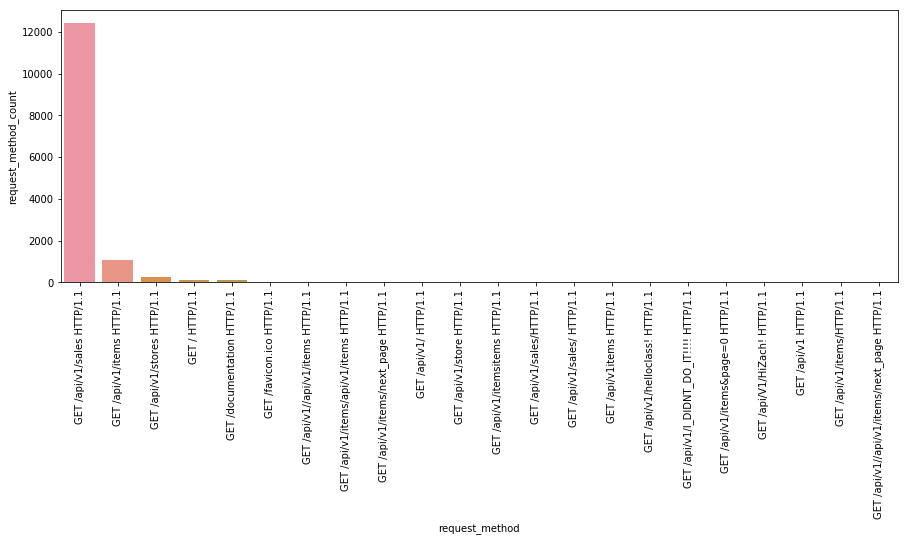

In [11]:
# plot outliers
plt.figure(figsize=(15, 5))
splot = sns.barplot(x = rm_df.request_method, y = rm_df.request_method_count, ci = None)
plt.xticks(rotation='vertical')

In [12]:
#again but with request agents:
ra_df = pd.DataFrame(df['request_agent'].value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_count'})
ra_df2 = pd.DataFrame(df['request_agent'].value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})
ra_df = ra_df.merge(ra_df2)
ra_df[ra_df.agent_proba < .01]

,request_agent,agent_count,agent_proba
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [13]:
print('Number of request agents: {}'.format(len(ra_df)))

print(ra_df.tail(7))

Number of request agents: 9
                                       request_agent  agent_count  agent_proba
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...           34     0.002432
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...            8     0.000572
4  Slackbot-LinkExpanding 1.0 (+https://api.slack...            7     0.000501
5       Slackbot 1.0 (+https://api.slack.com/robots)            6     0.000429
6  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            4     0.000286
7  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            2     0.000143
8                                  Python-urllib/3.7            1     0.000072


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

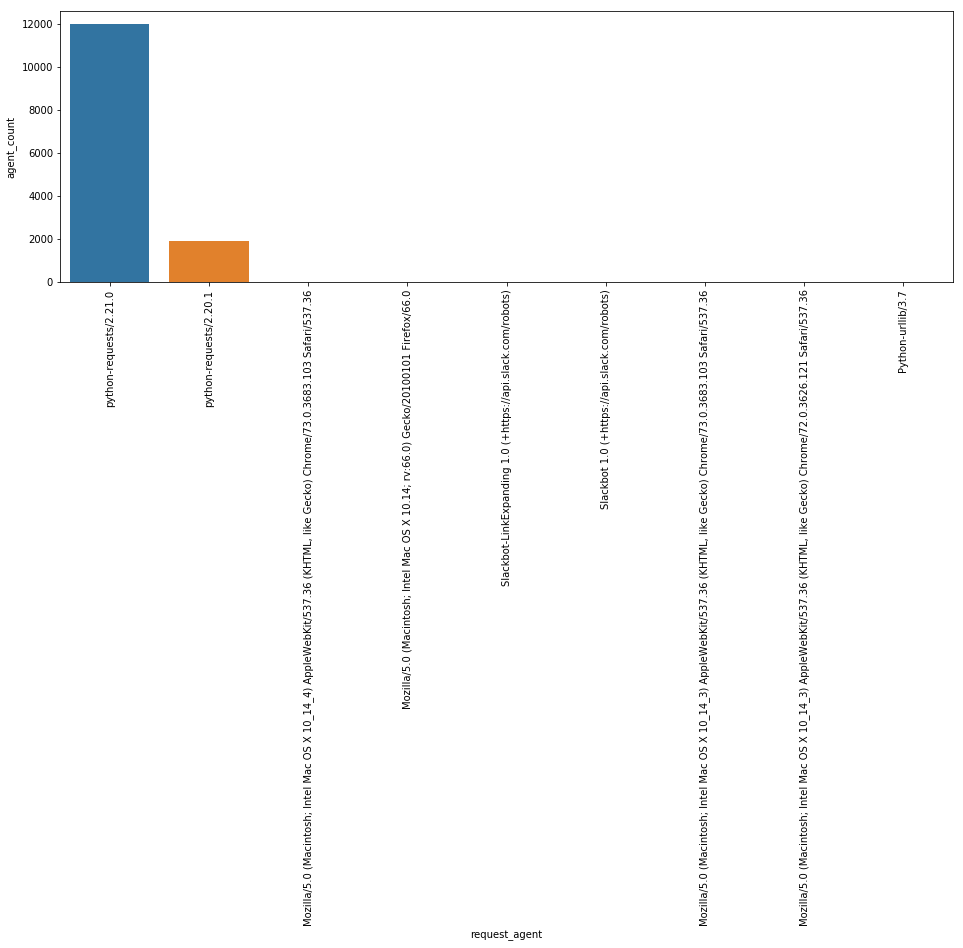

In [14]:
plt.figure(figsize=(16, 5))
sns.barplot(data=ra_df, x = 'request_agent', y = 'agent_count')
plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives

In [15]:
# create split
train = df['2019-04-16 19:34:42':'2019-04-16 21:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [16]:
# frame with request method, then again with request agent
rm_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})
ra_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})

In [17]:
# merge each dataframe with test probabilities
dfm = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
print(dfm.request_method_proba.value_counts())
df = df.reset_index().merge(ra_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
print(df.agent_proba.value_counts())

0.893049    12403
0.068612     1065
0.014439      229
0.009460      107
0.009062      100
0.001892       26
0.000498       12
0.000100       12
0.001095       11
0.000000        7
0.000299        6
Name: request_method_proba, dtype: int64
0.805716    12005
0.190301     1911
0.002589       34
0.000000       10
0.000597        7
0.000498        6
0.000199        4
0.000100        1
Name: agent_proba, dtype: int64


## Conditional Probabilities: probabilities using 2 discrete variables (request agent, ip)

In [18]:
# create probabilities of request agent based on occurance in dataframe
ra_probs = train.groupby('request_agent').size().div(len(train))

In [19]:
# calculate probability of ip given 
ip_given_agent = pd.DataFrame(train.groupby(['request_agent', 'ip']).\
                               size().div(len(train)).\
                               div(ra_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_ip_given_agent'})
                              )

In [21]:
# aggregate to get ip count for each agent
agent_ip_count = pd.DataFrame(train.groupby(['request_agent', 'ip'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'agent_ip_count'}))

agent_status = ip_given_agent.merge(agent_ip_count)

In [23]:
#merge new columns onto original dataframe
df = df.reset_index().merge(agent_status, on=['request_agent', 'ip'], how='left').fillna(value=0).set_index('timestamp')

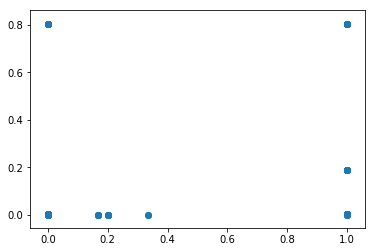

In [24]:
#plot probability of agent dependent on probability of ip given agent
plt.scatter(df.proba_ip_given_agent, df.agent_proba)

### Exercise Two: Time series + EMA
### Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

### Bonus:

### Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What is zach's id? What is maggie's id?


In [53]:
# some functions to get the data from the access log:
def read_log_cr():
    with open('anonymized-curriculum-access.txt') as f:
        lines = f.read()
        return lines
def split_content(lines):
    lines = lines.split('\n')
    return lines

def split_lines(lines):
    new_lines = []
    for line in lines:
        new_lines.append(line.split(' '))
    return new_lines

In [54]:
# use first function
lines = read_log_cr()

In [55]:
# use second function, split lines
lines = split_content(lines)

In [56]:
# split again
lines = split_lines(lines)

In [57]:
for i, elmnt in enumerate(lines):
    elmnt[0:2] = [' '.join(elmnt[0:2])]

In [58]:
# investigate to see if format is clean for rows
lines[0]

['2018-01-26 09:55:03', '/', '1', '8', '97.105.19.61']

In [59]:
# turn into pandas dataframe
dfc =pd.DataFrame(lines, columns=['timestamp','page','student','cohort','ip'])

In [60]:
# convert timestamp to datetime format
dfc.timestamp = pd.to_datetime(dfc.timestamp)

In [61]:
# check out frame, parse for null values
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233529 entries, 0 to 233528
Data columns (total 5 columns):
timestamp    233528 non-null datetime64[ns]
page         233528 non-null object
student      233528 non-null object
cohort       233528 non-null object
ip           233528 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 8.9+ MB


In [63]:
# set index to datetime
dfc = dfc.set_index('timestamp')

In [47]:
# pick a single cohort and run the time series analysis on that.

In [64]:
#drop last row that appears to be trash data/error
dfc.drop(dfc.tail(1).index,inplace=True)

In [65]:
# format cohort number to remove NaNs
dfc['cohort'] = pd.to_numeric(dfc['cohort'], errors='coerce')

dfc['cohort'] = dfc['cohort'].replace(np.nan, 0)

dfc['cohort'] = dfc.cohort.astype(int)

In [66]:
# dataframe resampled by day for student count in cohort 21
df_access = dfc[dfc.cohort == 21]['student'].resample('D').nunique()
dfc[dfc.cohort == 21].student.value_counts()

10     732
153    718
41     609
110    510
27     482
38     370
15     288
28     279
36     243
52     234
42     199
22     199
16     190
47     183
57     182
17     175
56     170
33     151
255    114
65     106
175    102
55      95
45      65
24      26
49      25
286     12
115      6
Name: student, dtype: int64

In [67]:
# create index of date ranges by day, fill empty values
idx = pd.date_range(
    df_access.sort_index().index.min(), 
    df_access.sort_index().index.max(),
    freq='D'
)

df_access = df_access.reindex(idx, fill_value=1).fillna(value=1)

In [68]:
# make train/test split for this cohort based on a reasonable amount of time after cohort graduation 
start_date_train = df_access.head(1).index[0]
end_date_train = '2018-06-29'
start_date_test = '2018-06-30'

train = df_access[:end_date_train]
test = df_access[start_date_test:]

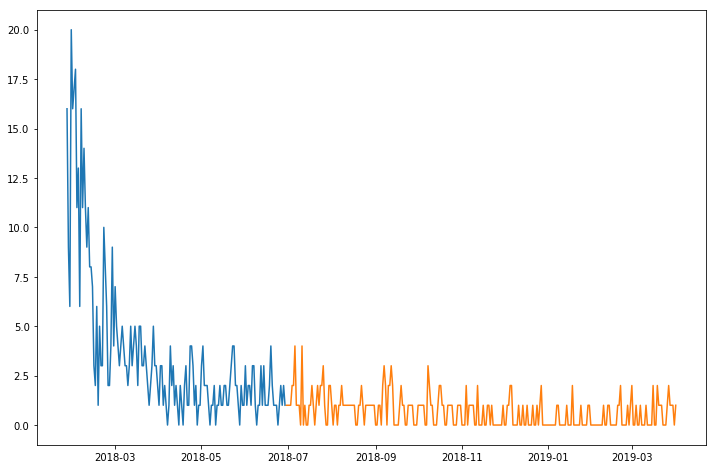

In [69]:
# plot train and test
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

In [70]:
# aggregate by count for student to represent hits attibuted to each student
dfc.groupby('student').count()

,page,cohort,ip
student,,,
1,2639,2639,2639
10,732,732,732
100,59,59,59
101,203,203,203
102,80,80,80
103,42,42,42
104,8,8,8
105,227,227,227
106,102,102,102


In [71]:
# two rolling mean creations based on 30 day and 60 day windows
short_rolling = train.rolling(window=30).mean()

long_rolling = train.rolling(window=60).mean()

Text(0, 0.5, 'students')

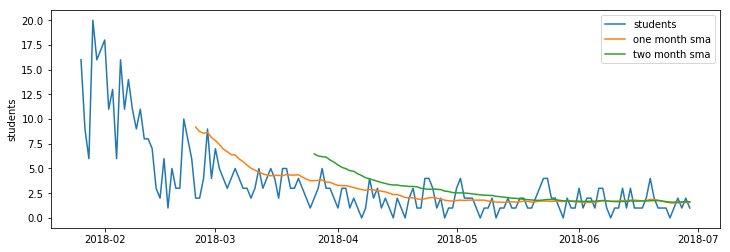

In [72]:
# plot one month and two month averages on train/test
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='students')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = 'one month sma')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = 'two month sma')

ax.legend(loc='best')
ax.set_ylabel('students')


In [73]:
#create exponential moving averages
ema_short = train.ewm(span=30, adjust=False).mean()
ema_long = train.ewm(span=60, adjust=False).mean()

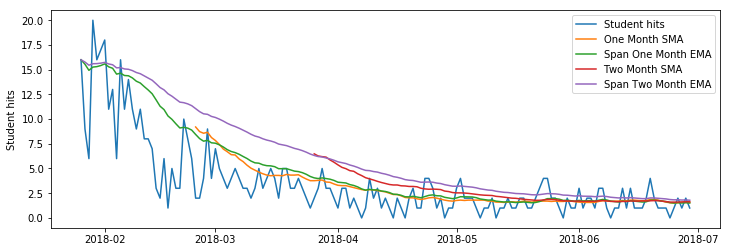

In [74]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Student hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = 'One Month SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span One Month EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = 'Two Month SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span Two Month EMA')

ax.legend(loc='best')
ax.set_ylabel('Student hits')

yhat = pd.DataFrame(dict(actual=test))

In [75]:
# create bands of 3 standard deviations out
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3
yhat['moving_avg_forecast'] = midband

In [76]:
#use ema_long to forecast and calculate error
yhat['moving_avg_forecast'] = ema_long.iloc[-1]

yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

q3 = yhat.error.describe().loc['75%']
q1 = yhat.error.describe().loc['25%']

In [77]:
# calculate %b
yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [78]:
#display all %b's over 1, showing outliers for hits on days for cohort
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2018-07-06,4,1.788687,2.211313,3.801920
2018-07-11,4,1.788687,2.211313,3.801920
2018-07-26,3,1.788687,1.211313,2.308726
2018-09-07,3,1.788687,1.211313,2.308726
2018-09-12,3,1.788687,1.211313,2.308726
2018-10-08,3,1.788687,1.211313,2.308726


In [79]:
# use plot and evaluate functions from our timeseries block again
def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    
    
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

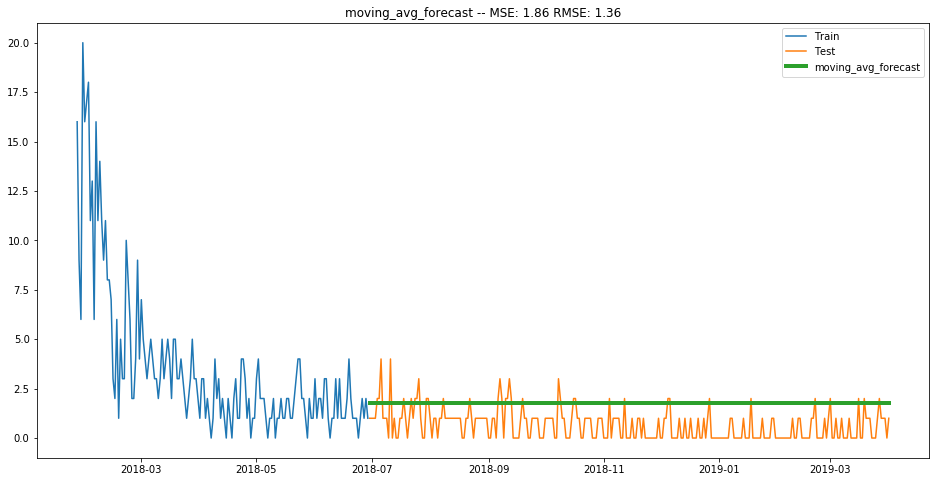

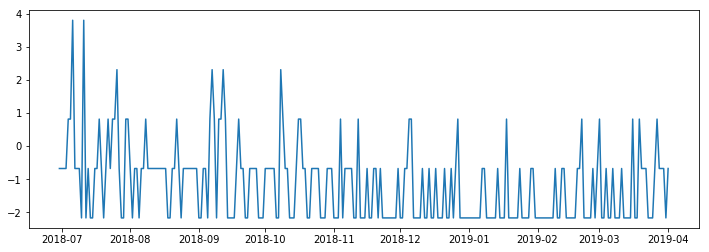

In [80]:
#compare our forecast to test data
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

### Utilizing the extra data given to the class regarding cohort names and course times:

In [81]:
# remake our student dataframe using some regex this time as displayed in curriculum
colnames=['date','page_viewed','user_id','cohort_id','ip']
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5]
)

In [82]:
# take care of nans and cast int type to cohort ids
df = df.dropna()
df.cohort_id = df.cohort_id.astype('int')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 233527
Data columns (total 5 columns):
date           219070 non-null object
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort_id      219070 non-null int64
ip             219070 non-null object
dtypes: int64(2), object(3)
memory usage: 10.0+ MB
None


,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8,97.105.19.61
1,2018-01-26,java-ii,1,8,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


In [83]:
# get the two new datasets
cohort_names = pd.read_csv('cohort_name_to_id.csv')
cohort_dates = pd.read_csv('cohort_dates.csv', index_col=False)

In [84]:
# make sure we have proper foreign keys to join
cohort_names.rename(columns={'id ': 'cohort_id'}, inplace=True)
df = df.merge(cohort_names, on='cohort_id', how='left')

In [85]:
# do that again
cohort_dates = cohort_dates[['name', 'start_date', 'end_date']]
df = df.merge(cohort_dates, on='name', how='left')

In [86]:
# make sure everything is in a datetime format
df['date'] = pd.to_datetime(df['date'])
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

In [87]:
# engineer feature that tells us if hit was made after course graduation date
df['after_course'] = (df.date > df.end_date).astype(int)

In [88]:
# aggregate by user id per date, count number of page views on the condition the view was made post-course.
df_agg = df[df.after_course == 1].groupby(['date','user_id'])['page_viewed'].\
                        count().\
                    reset_index().\
                    rename(index=str, 
                       columns={'page_viewed': 'hits'})

In [89]:
# peek
df_agg.head()

,date,user_id,hits
0,2018-01-26,1,7
1,2018-01-26,11,19
2,2018-01-26,21,2
3,2018-01-26,26,3
4,2018-01-26,37,4


In [90]:
# create crosstab to represent the same data as the aggregation
user_views = pd.crosstab(df[df.after_course == 1].date, df[df.after_course == 1].user_id)

In [91]:
#index the crosstab with datetime
user_views.index = pd.to_datetime(user_views.index)

In [92]:
# resample by week, assign to new frame
us_views_by_week = user_views.resample('W').sum().loc[:, 0:25]

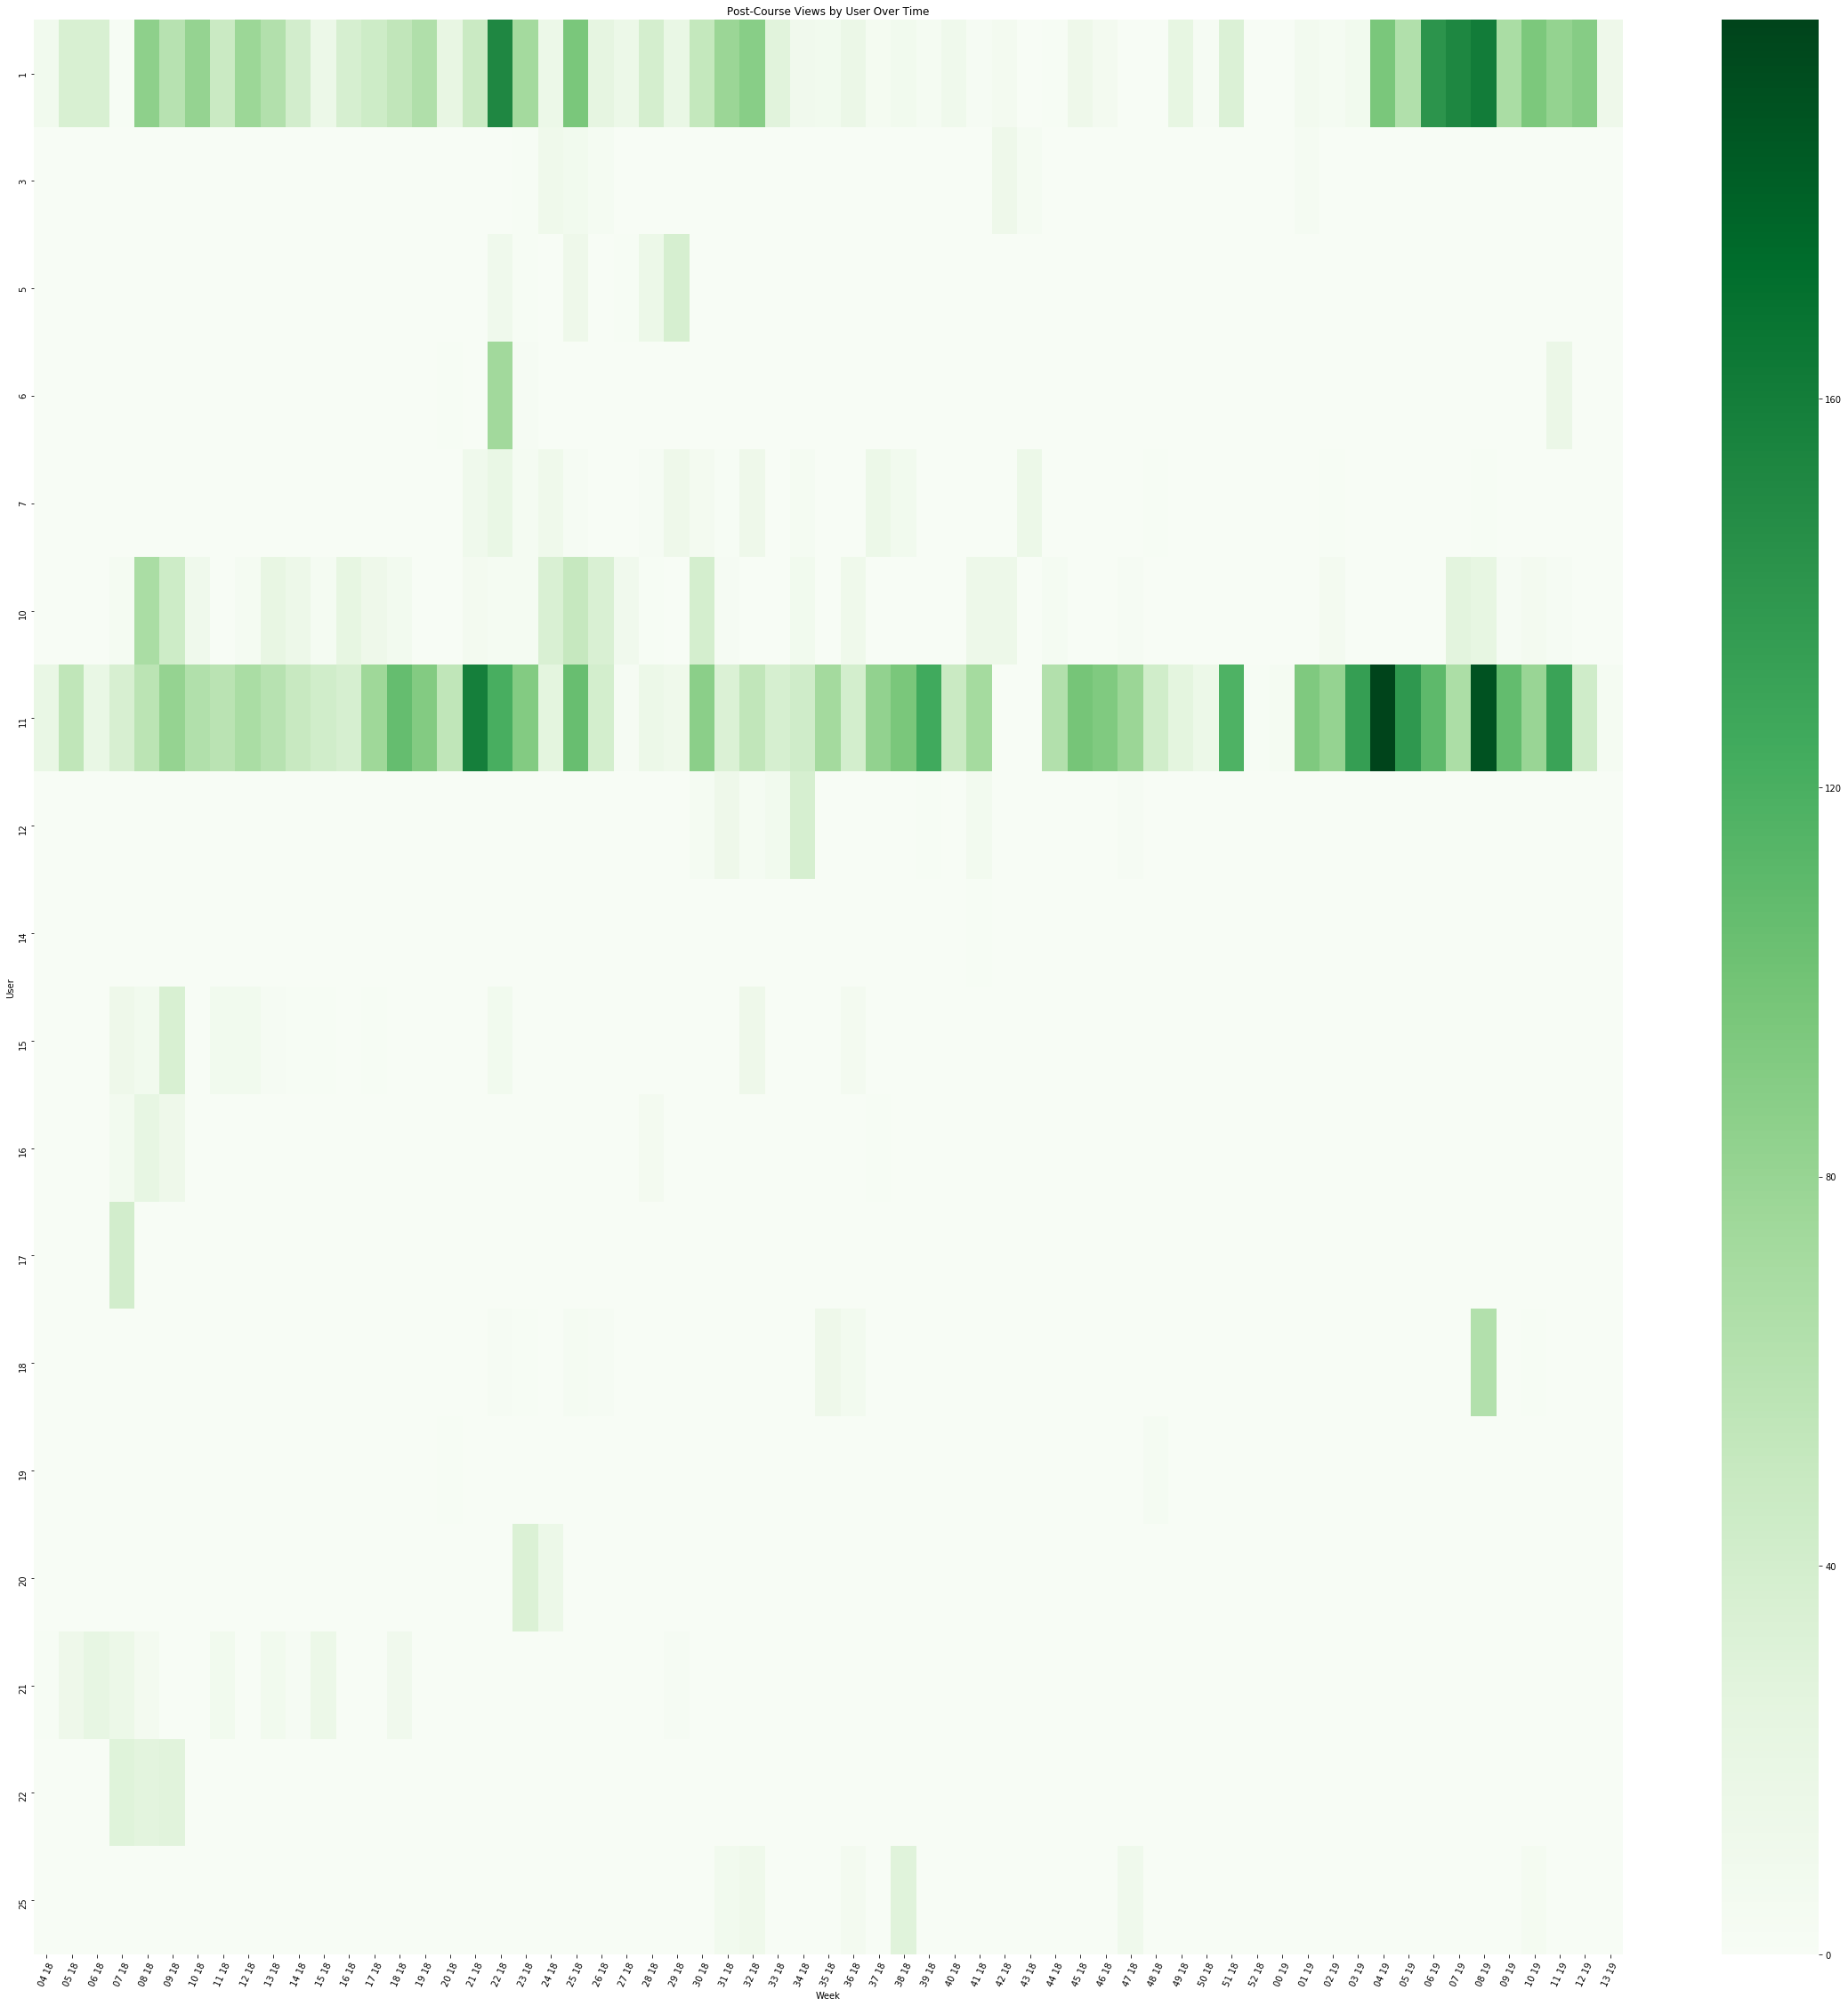

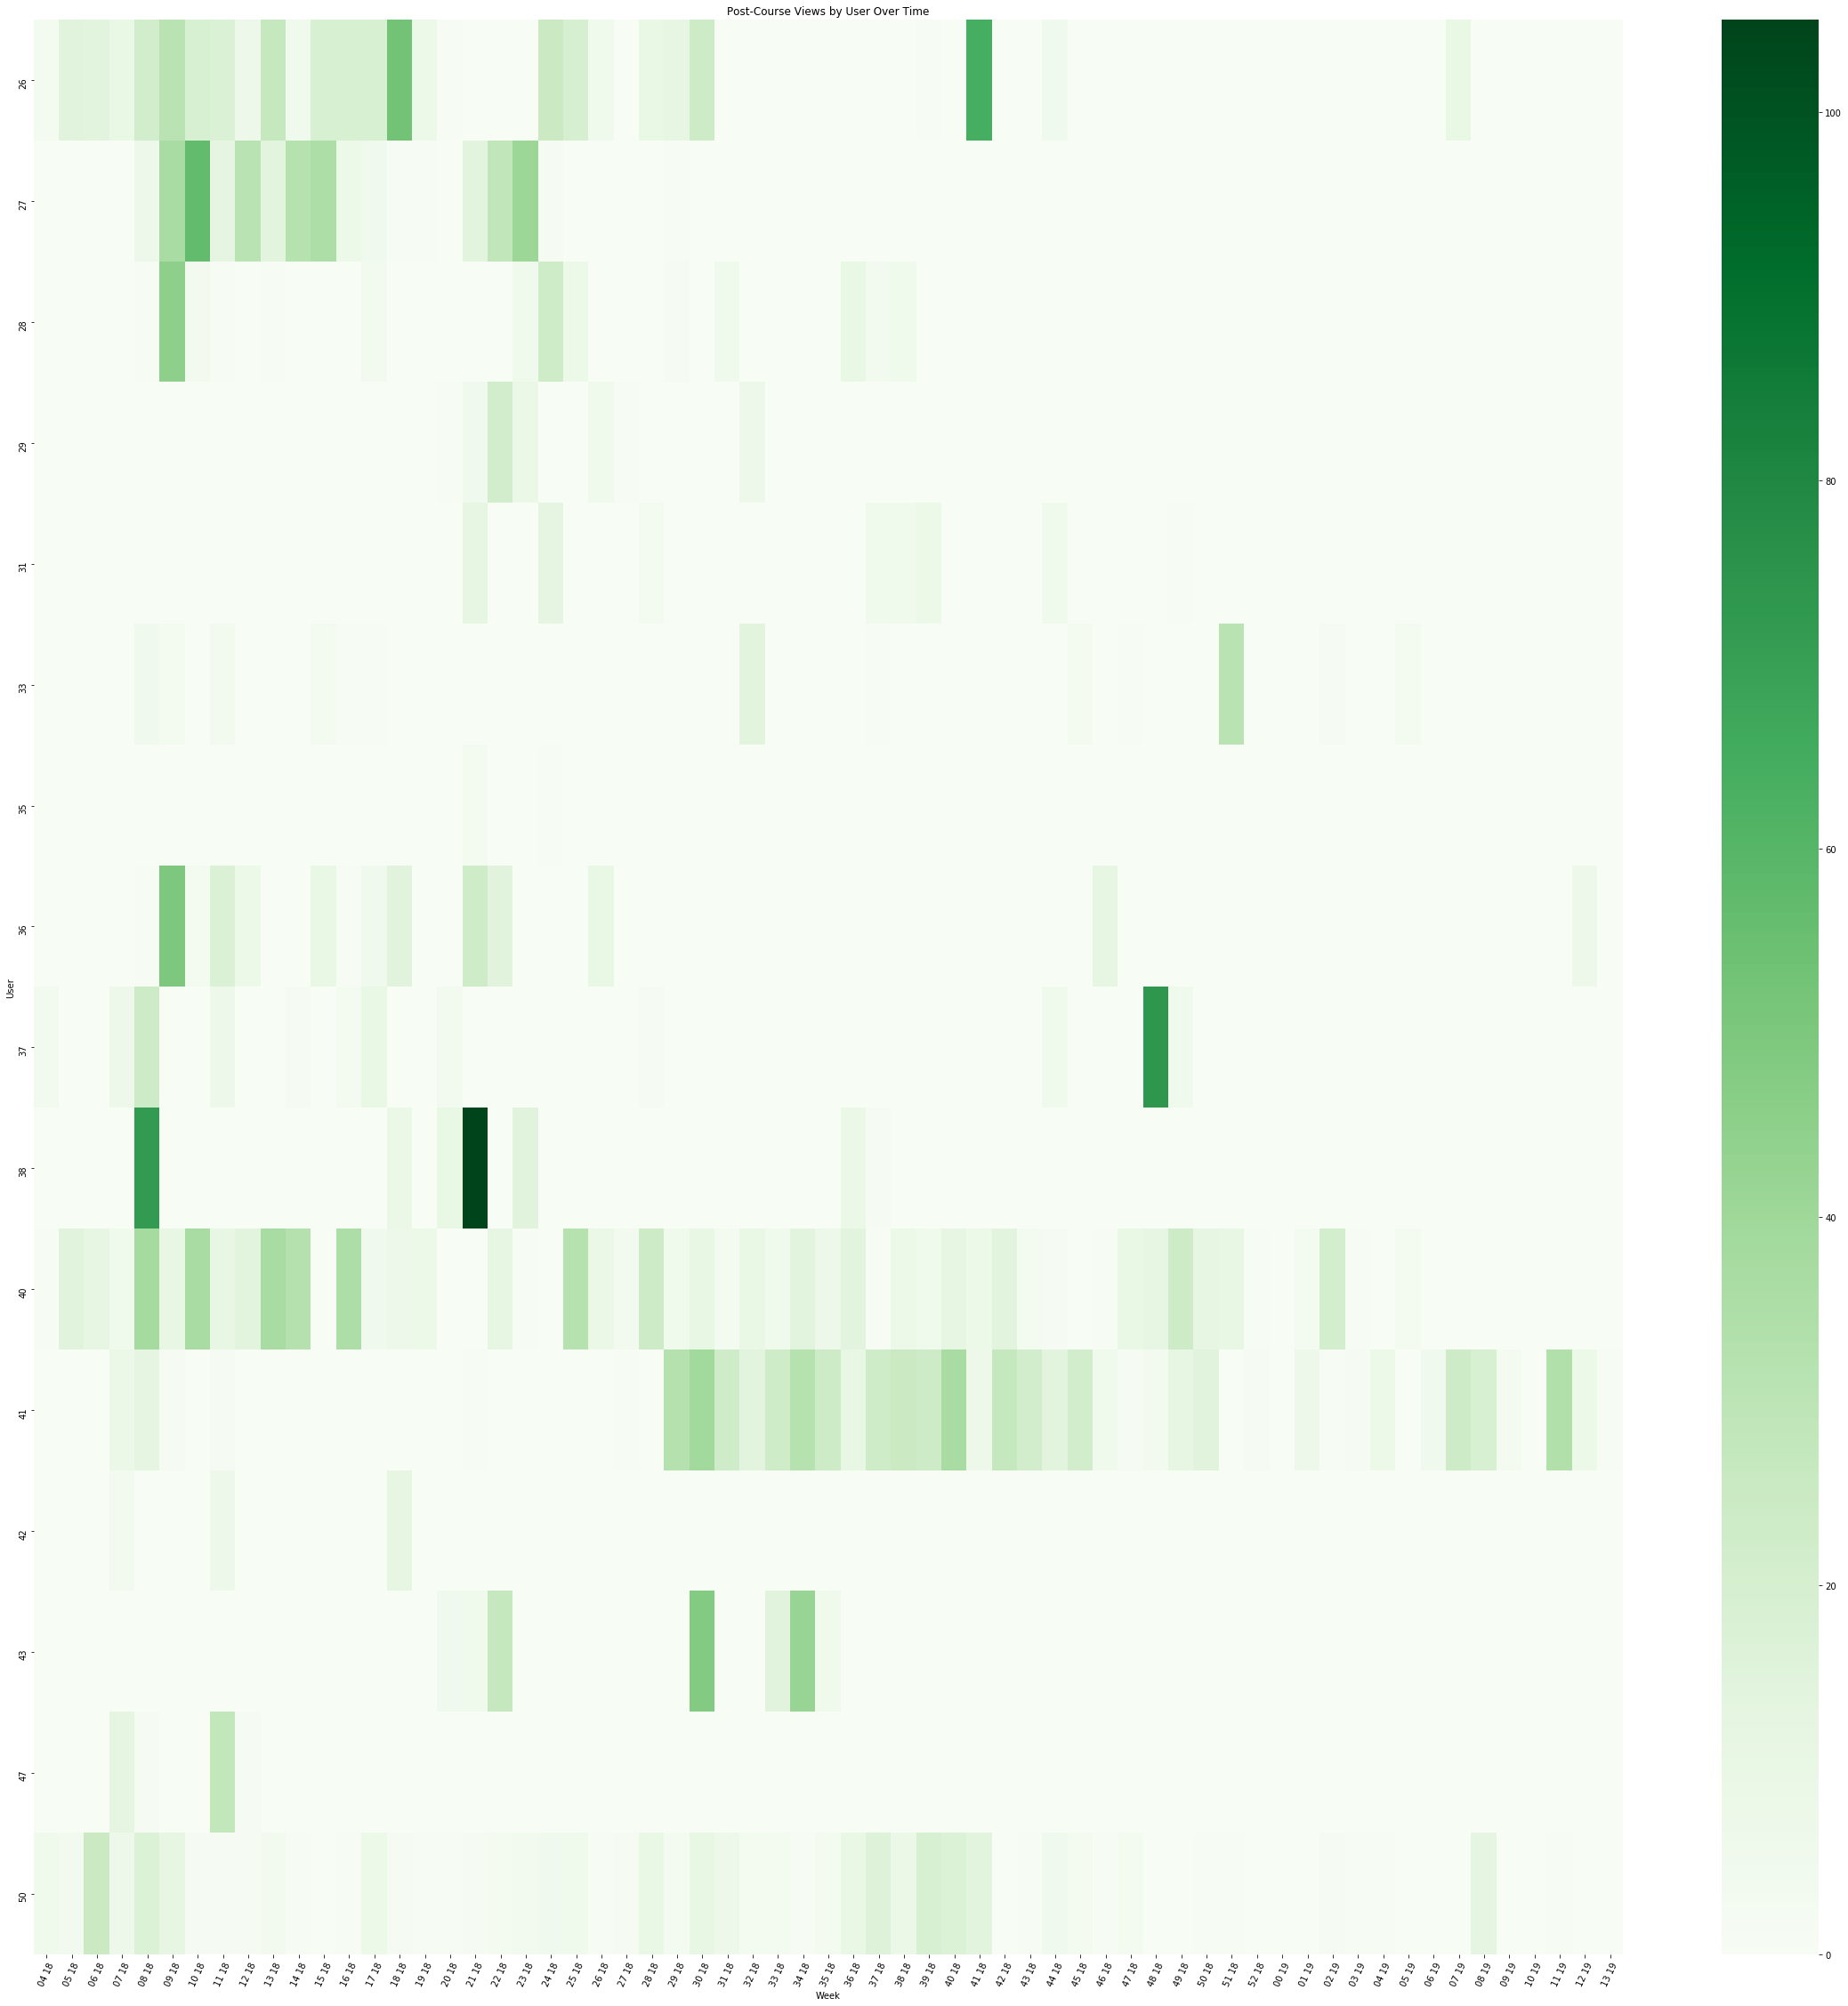

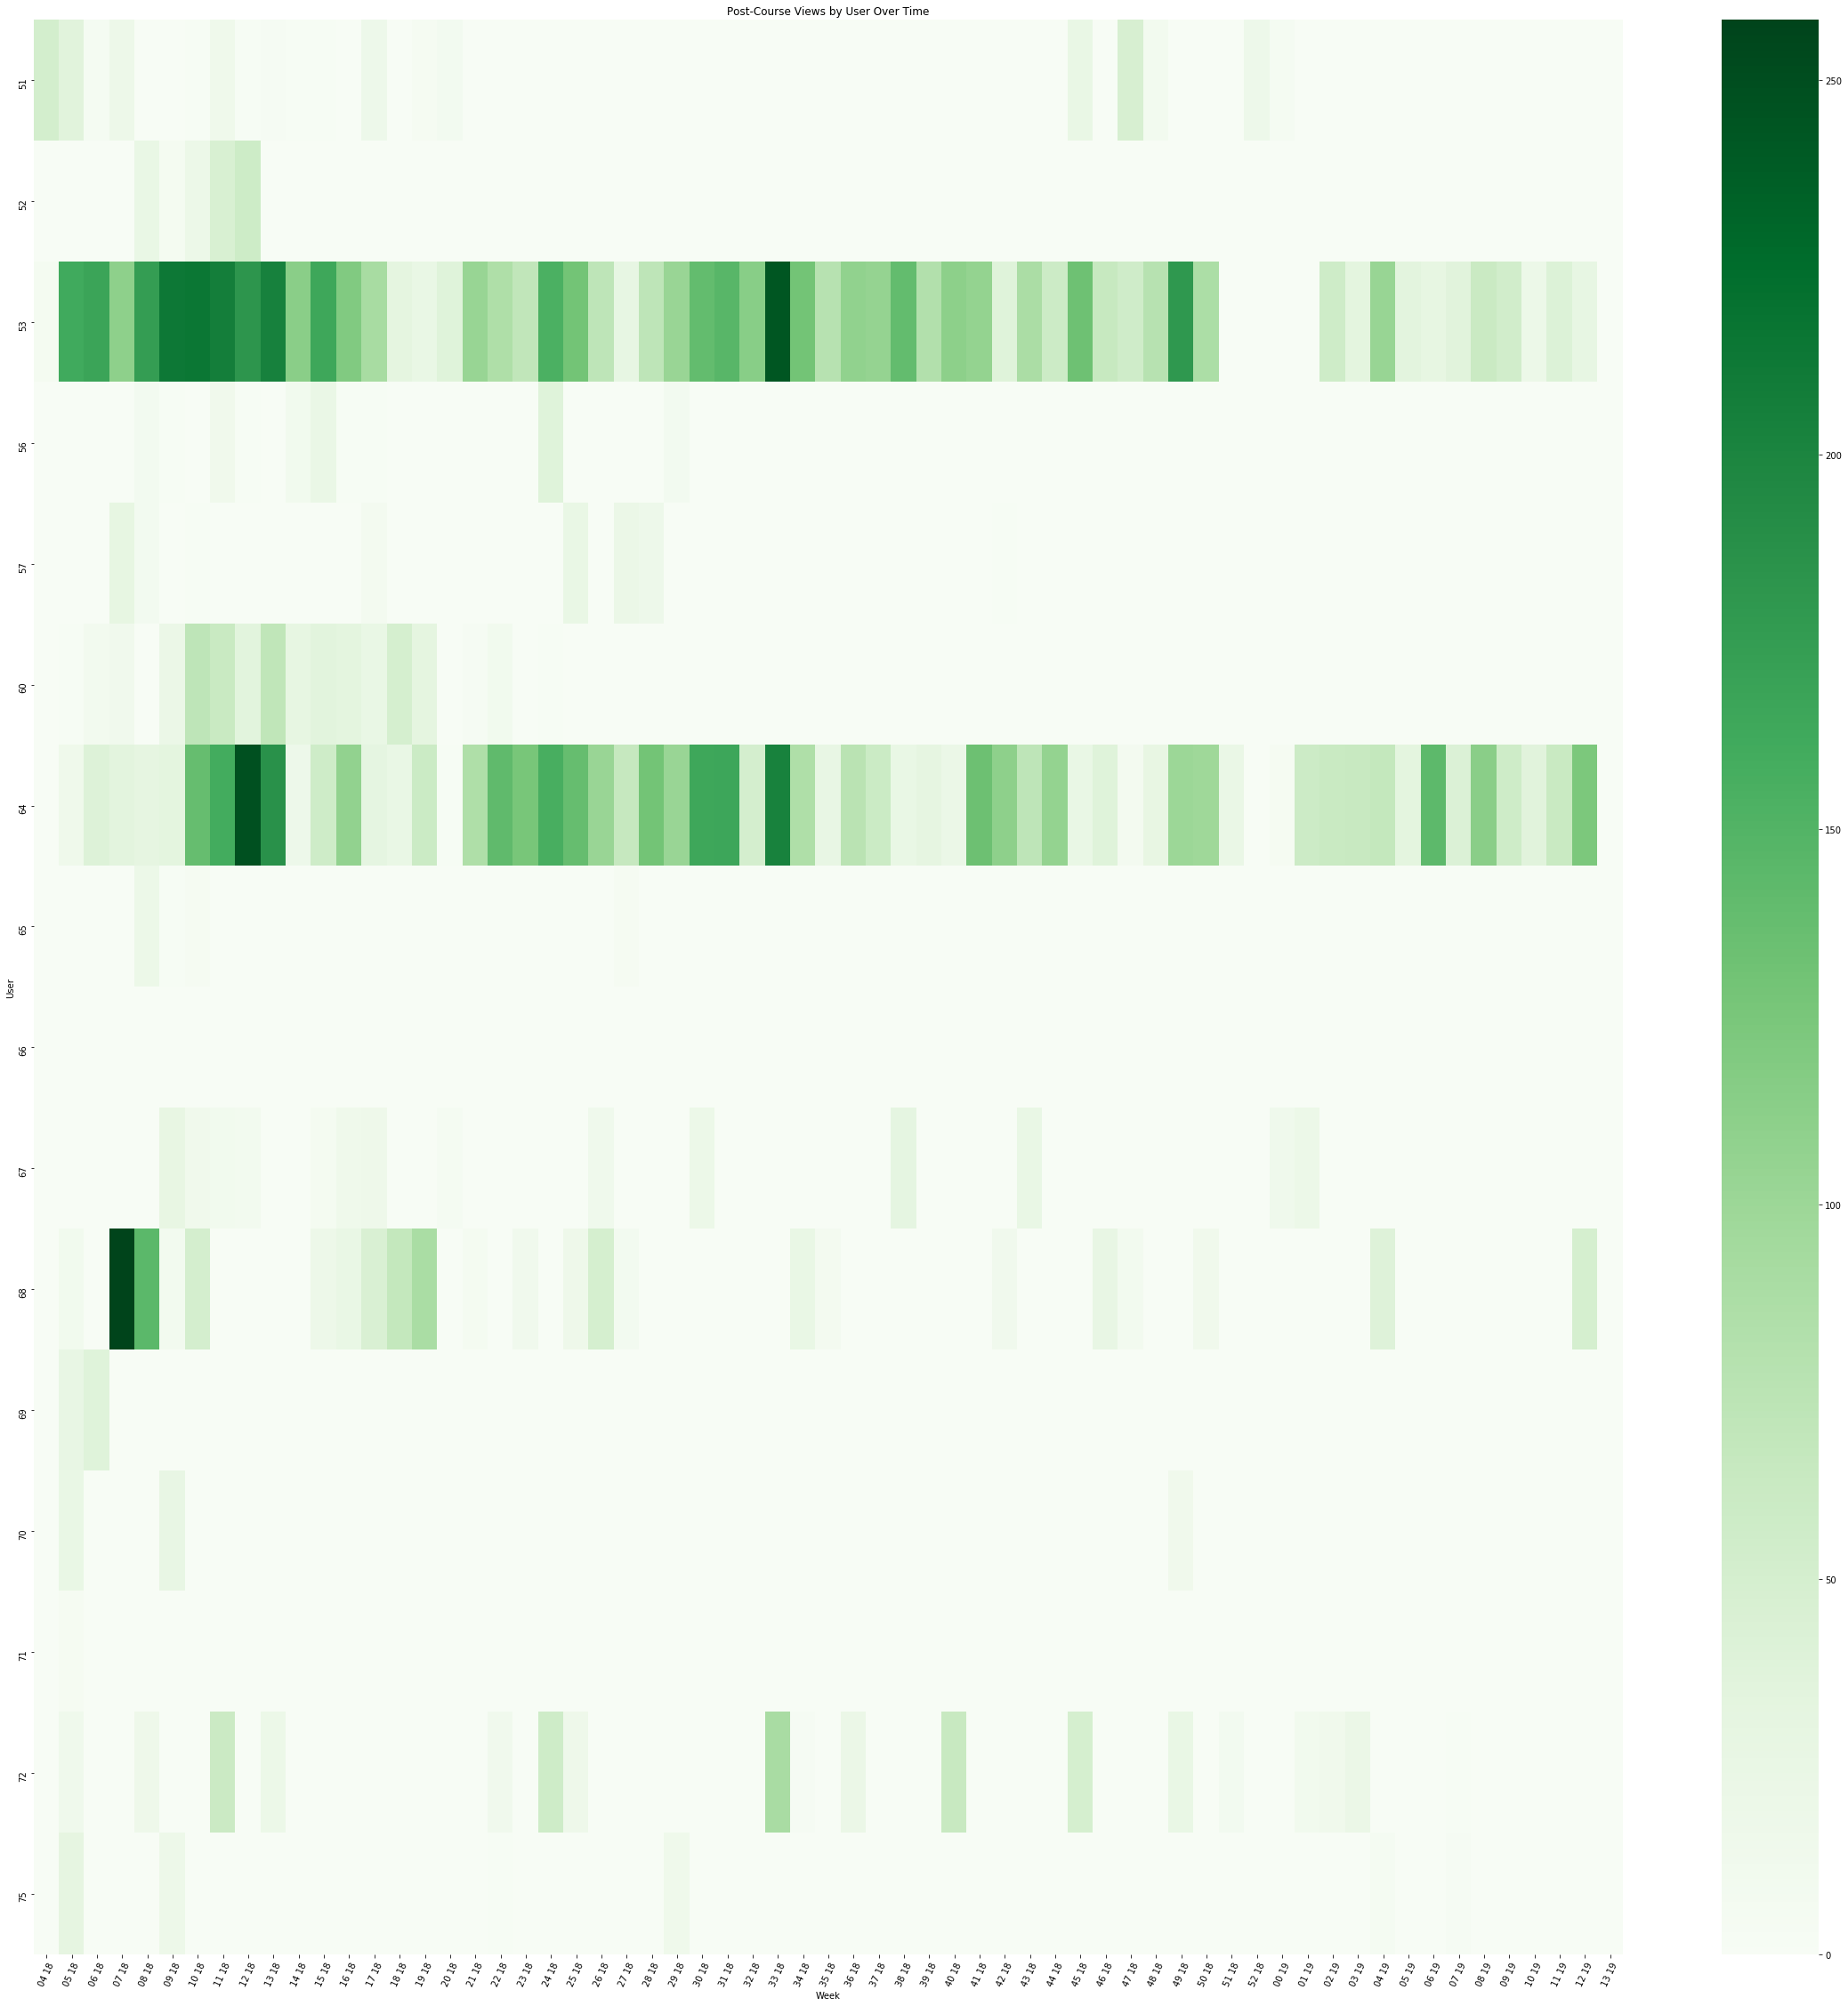

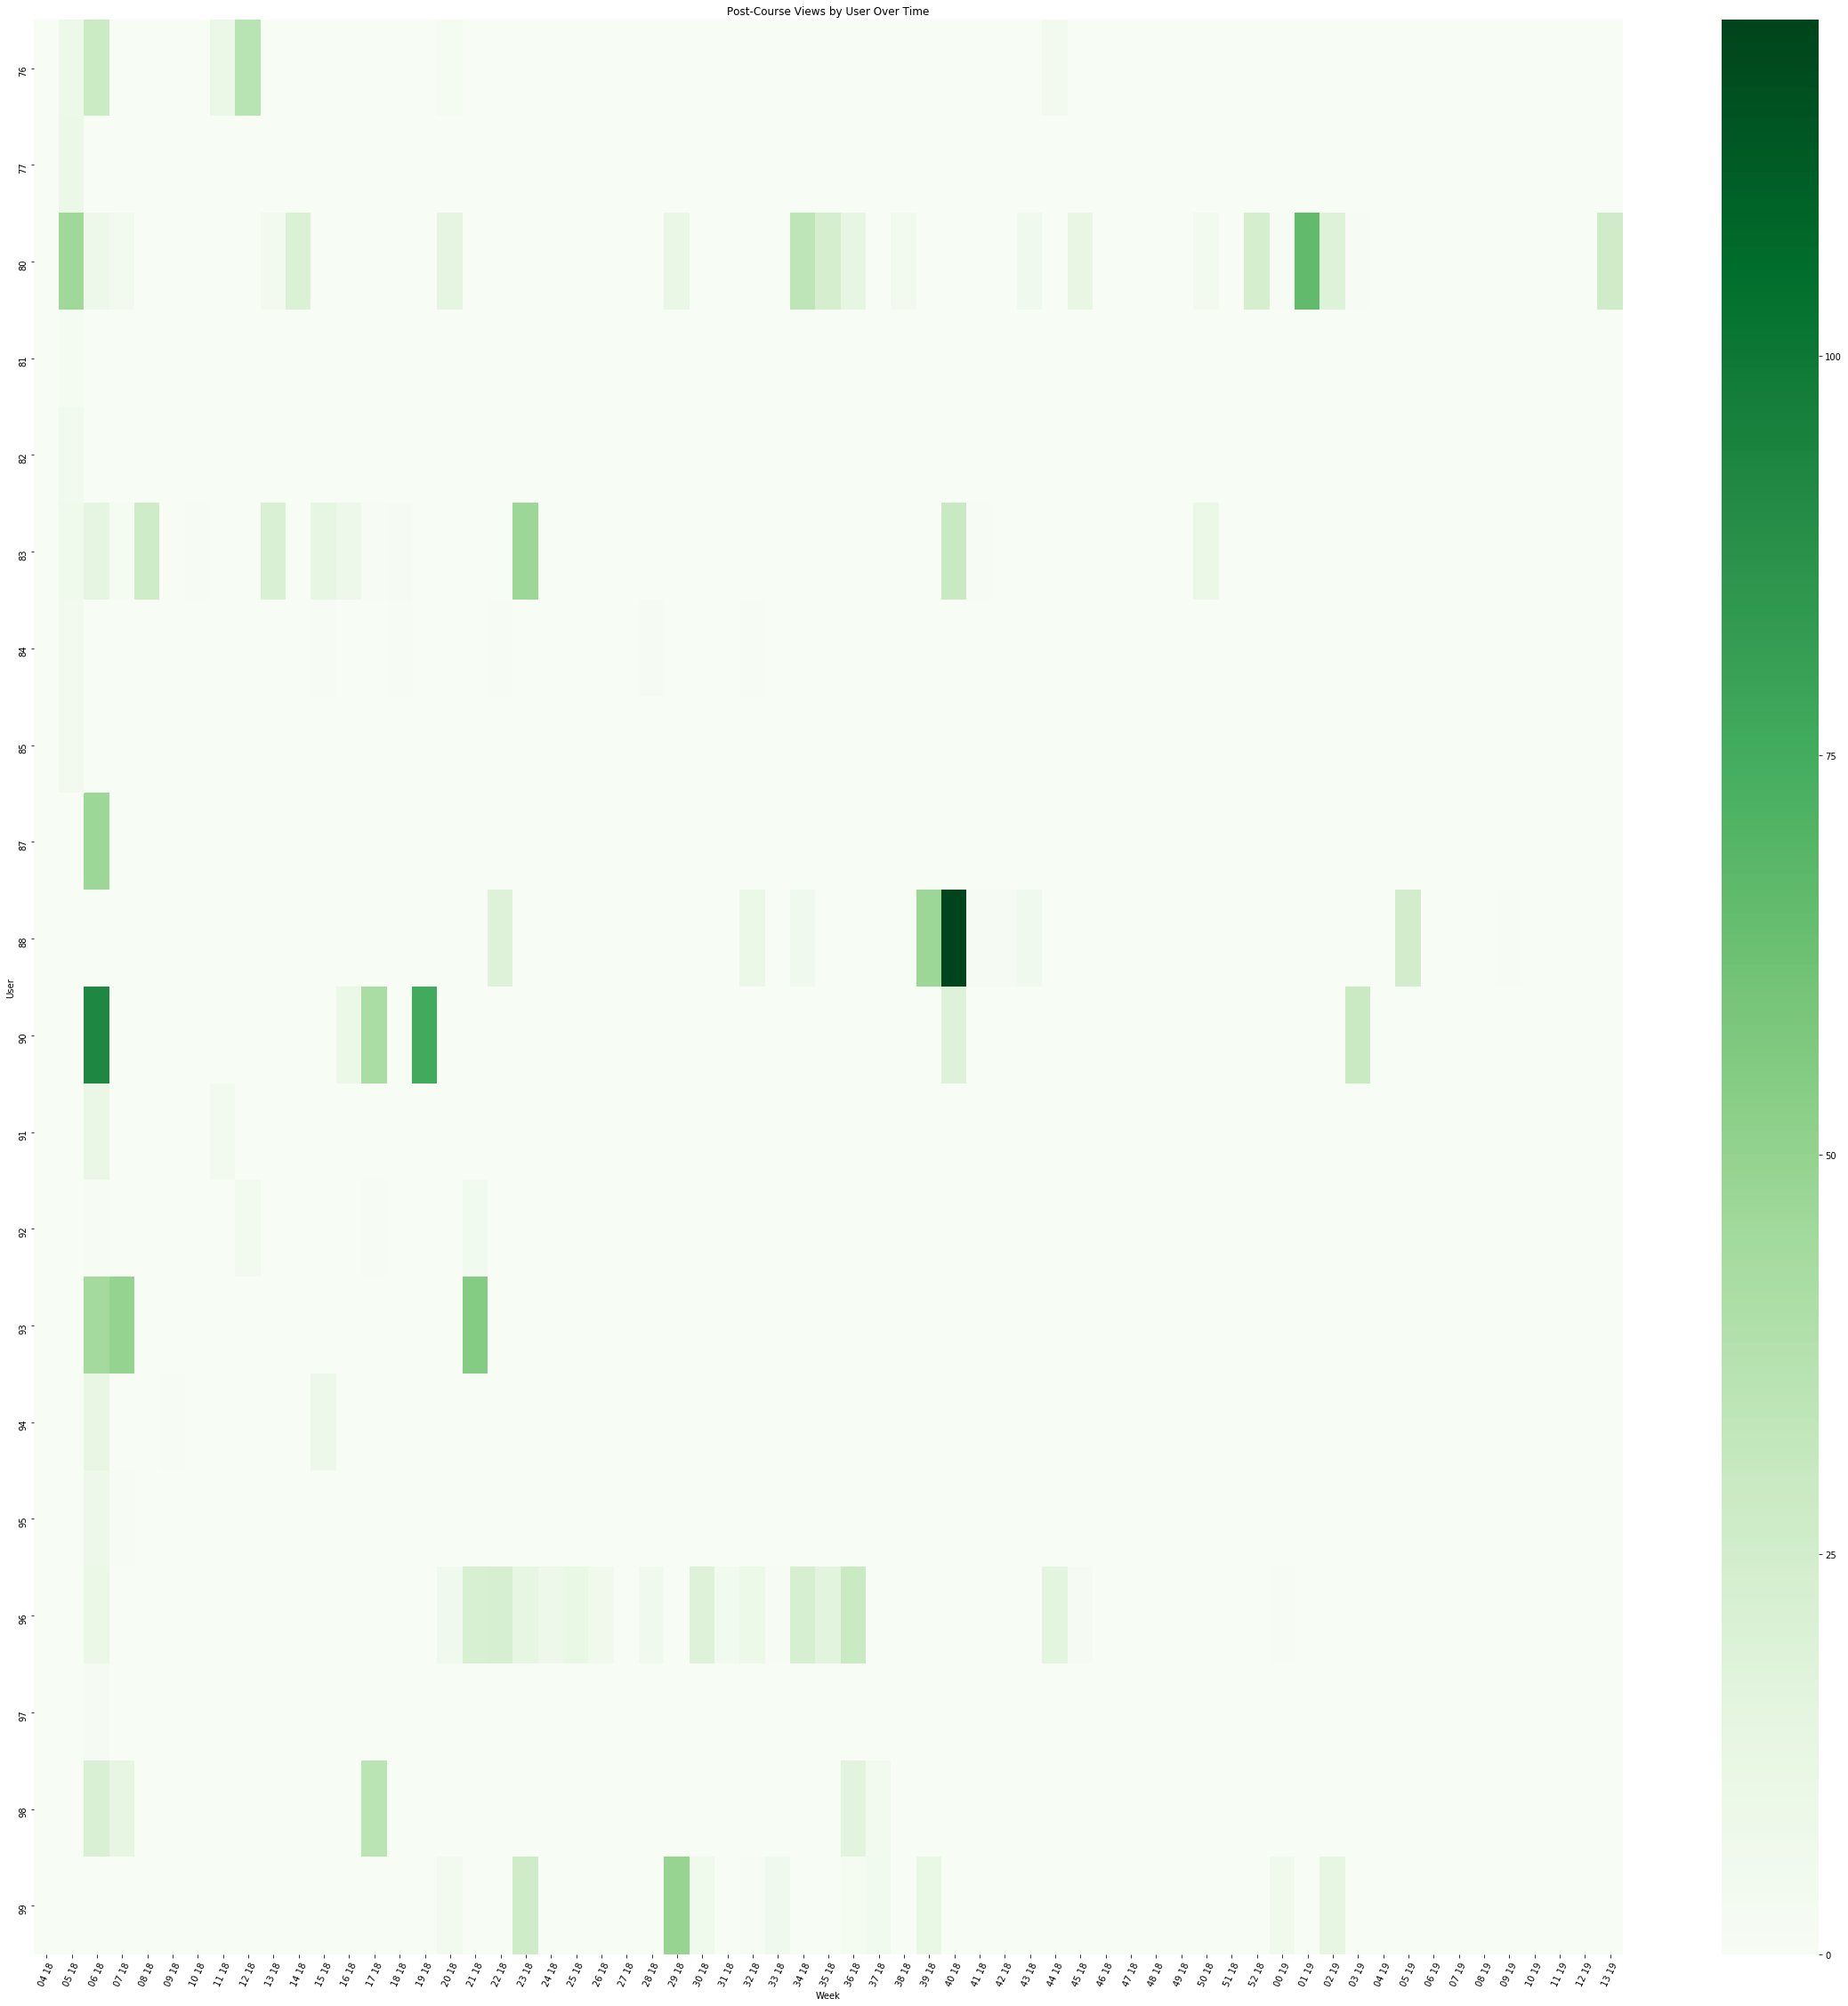

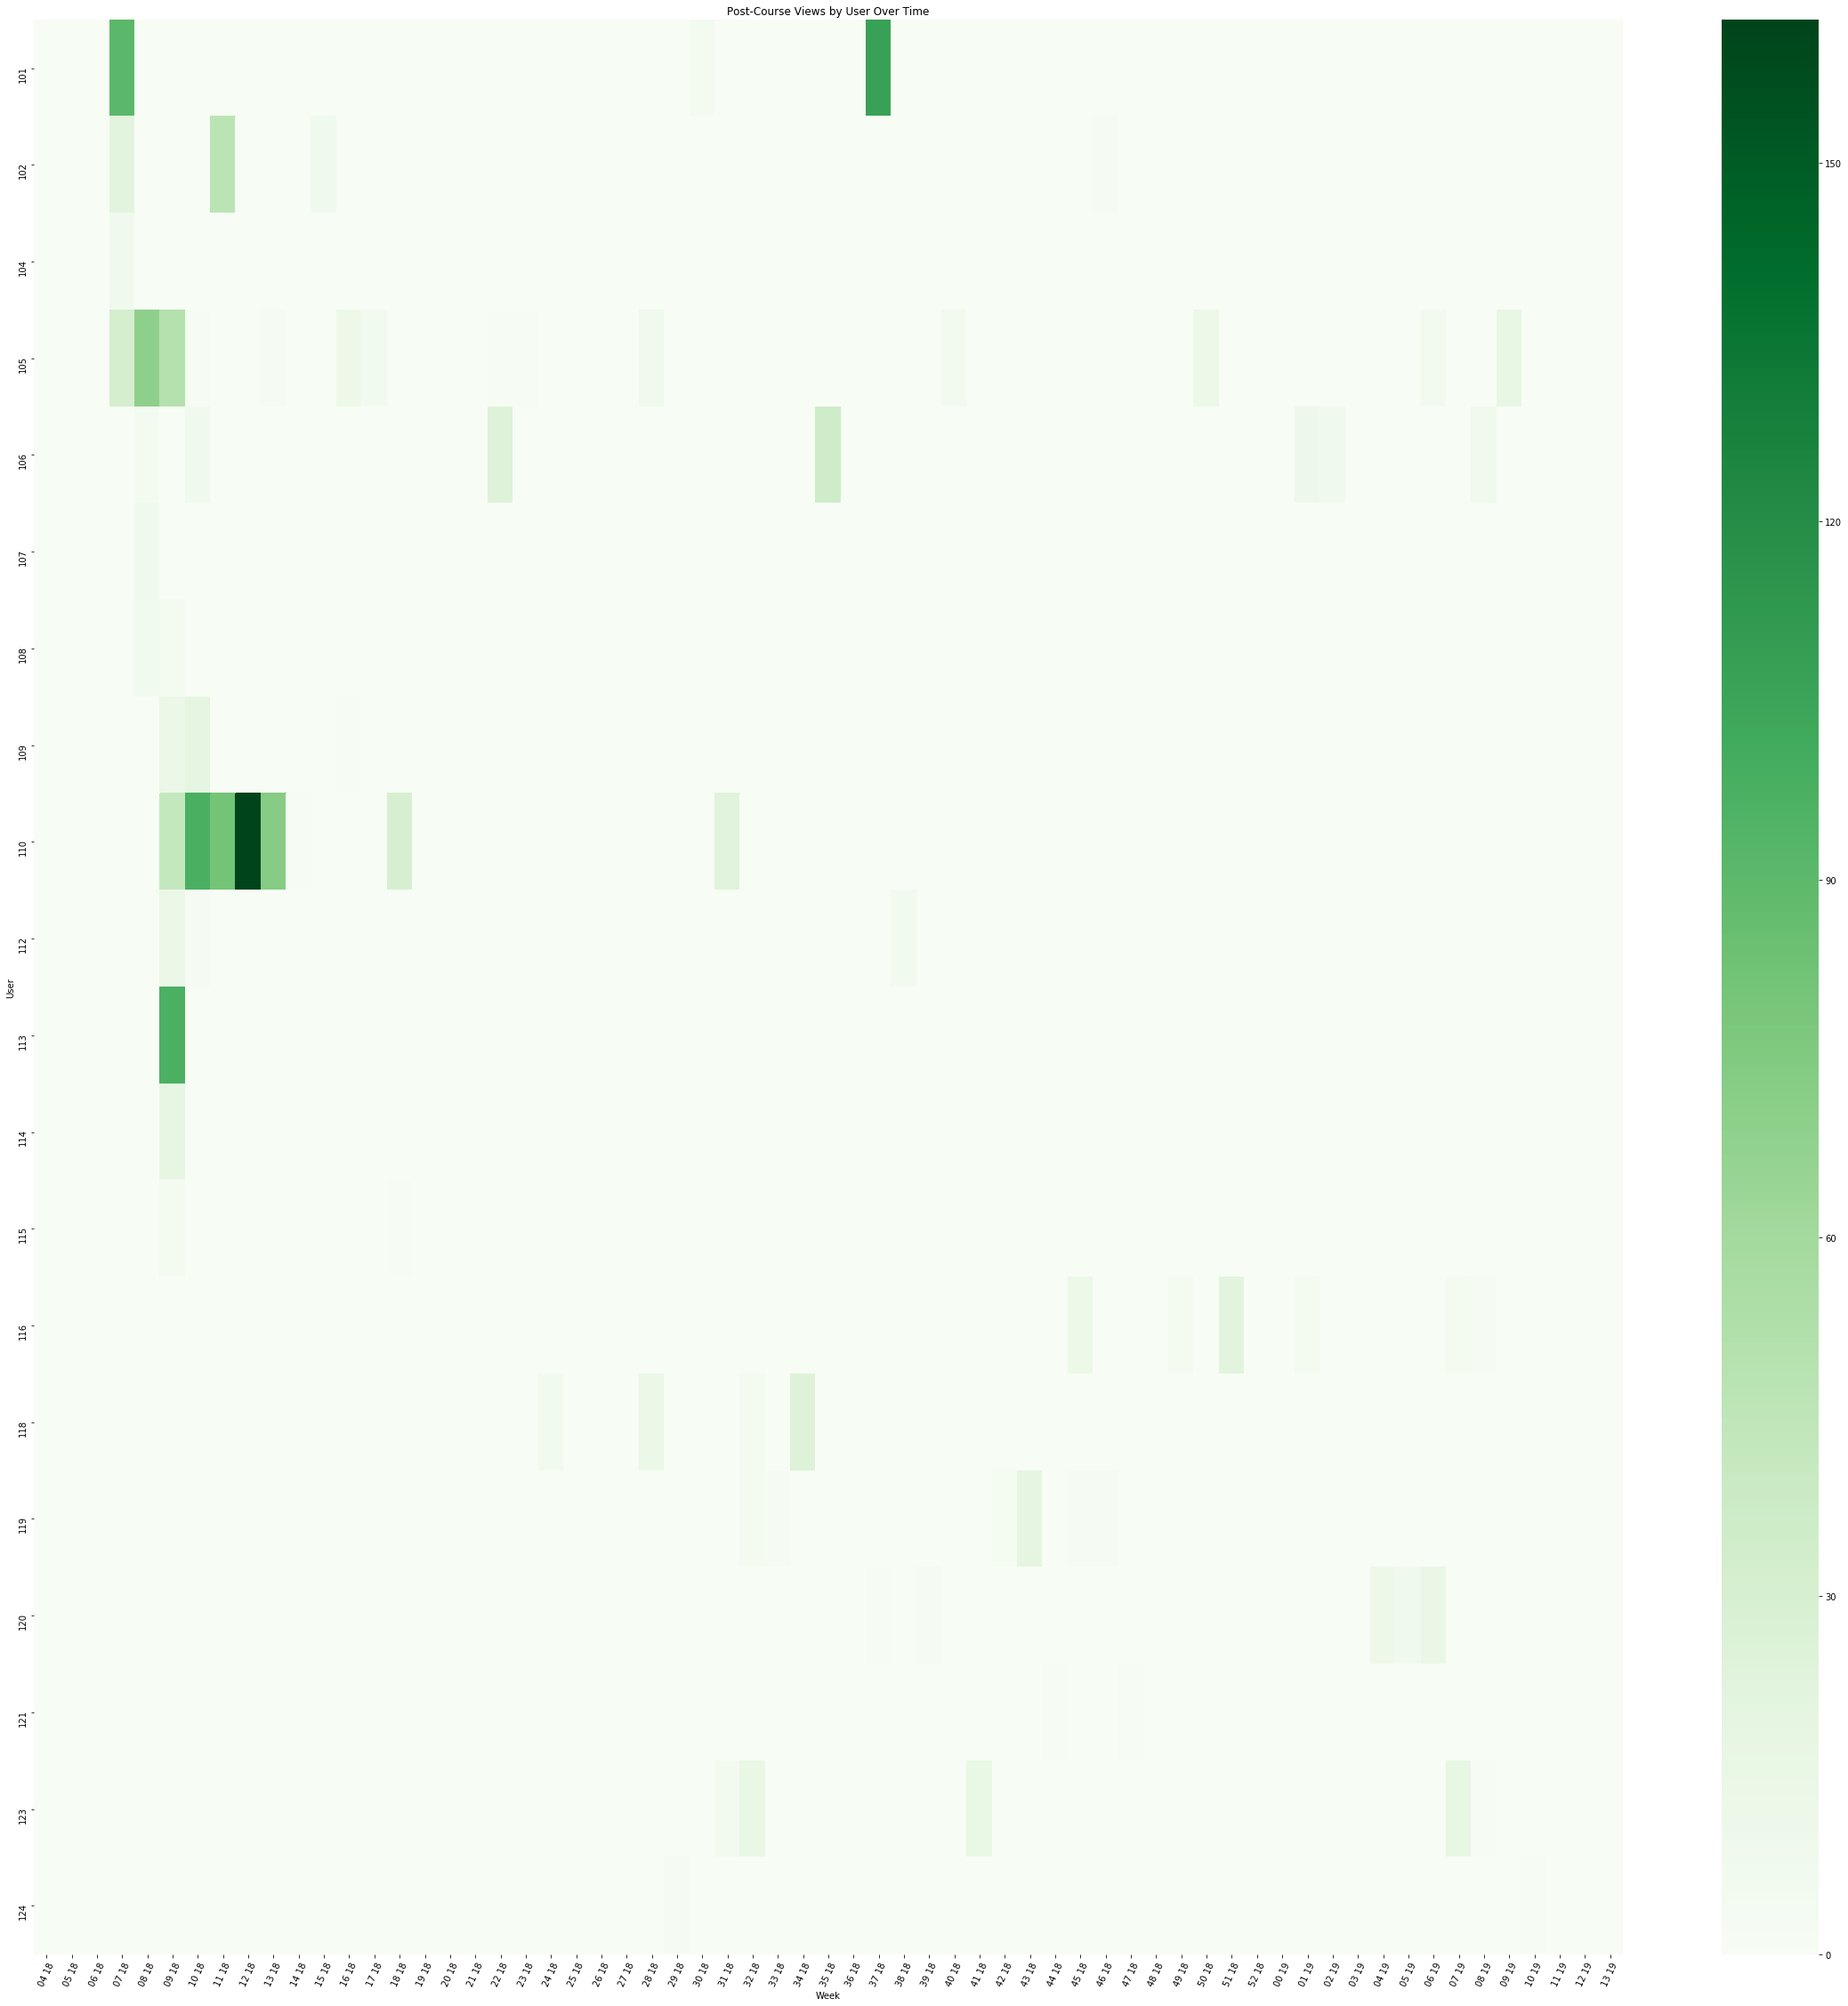

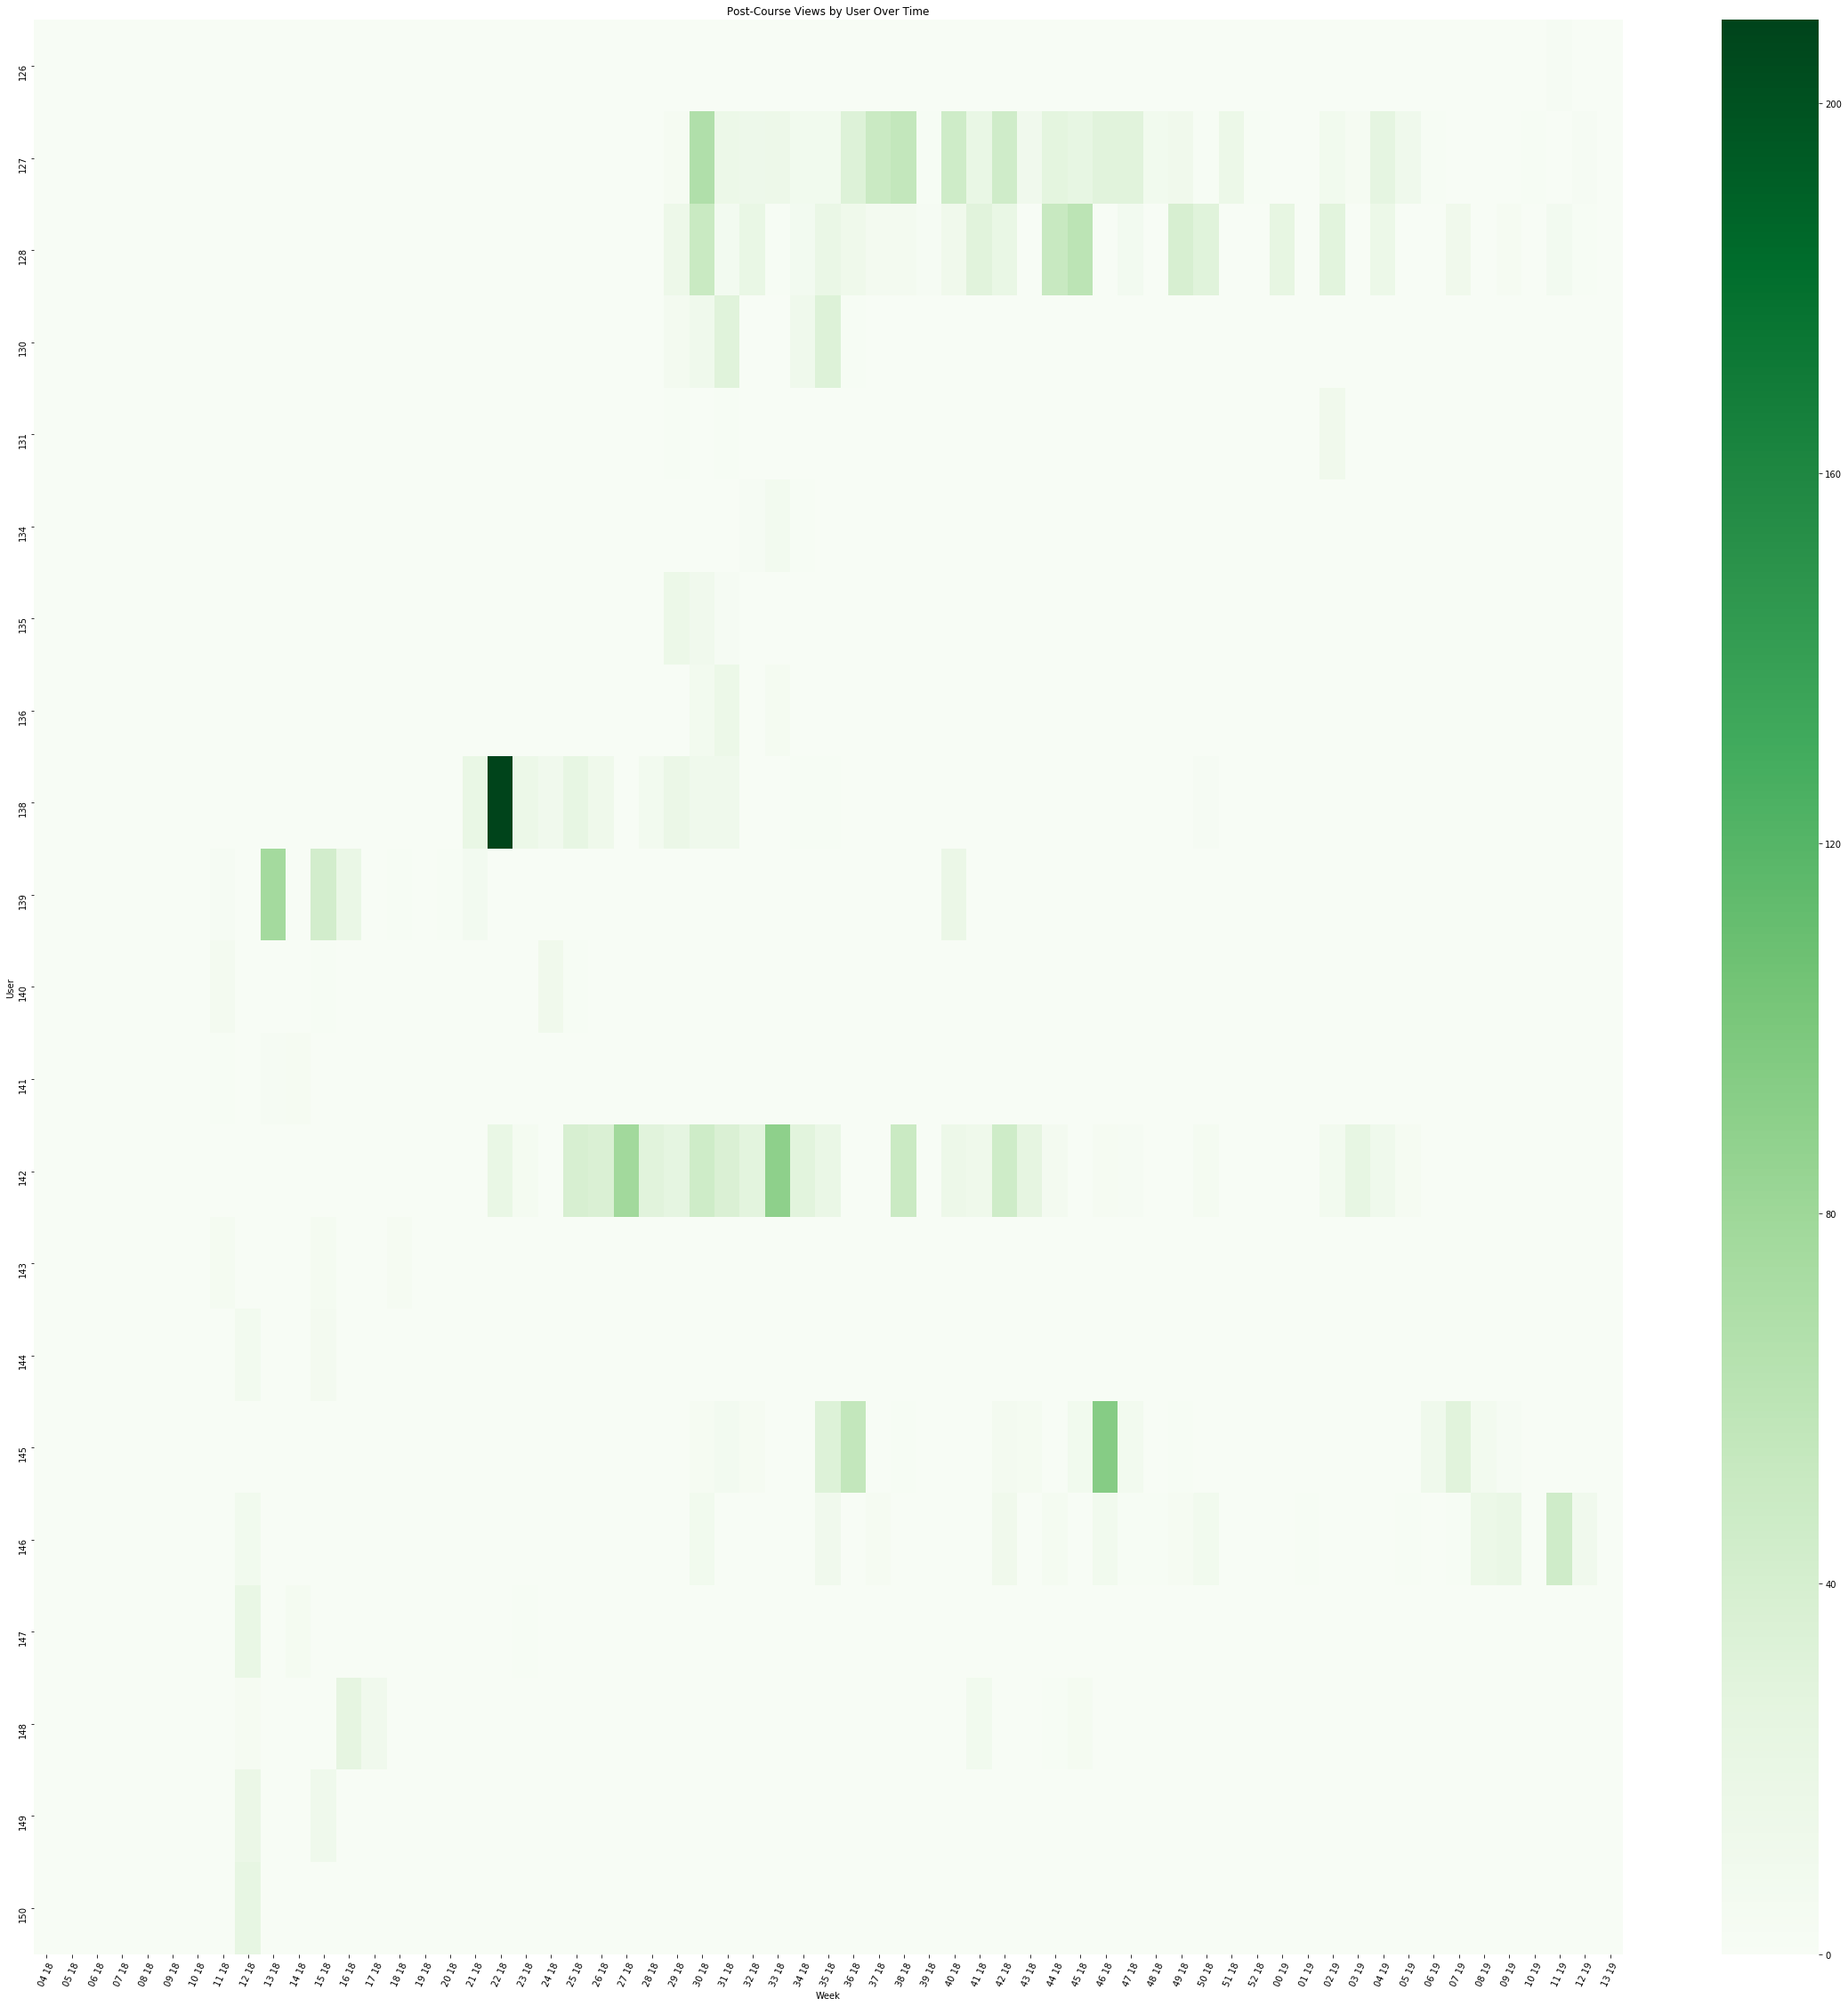

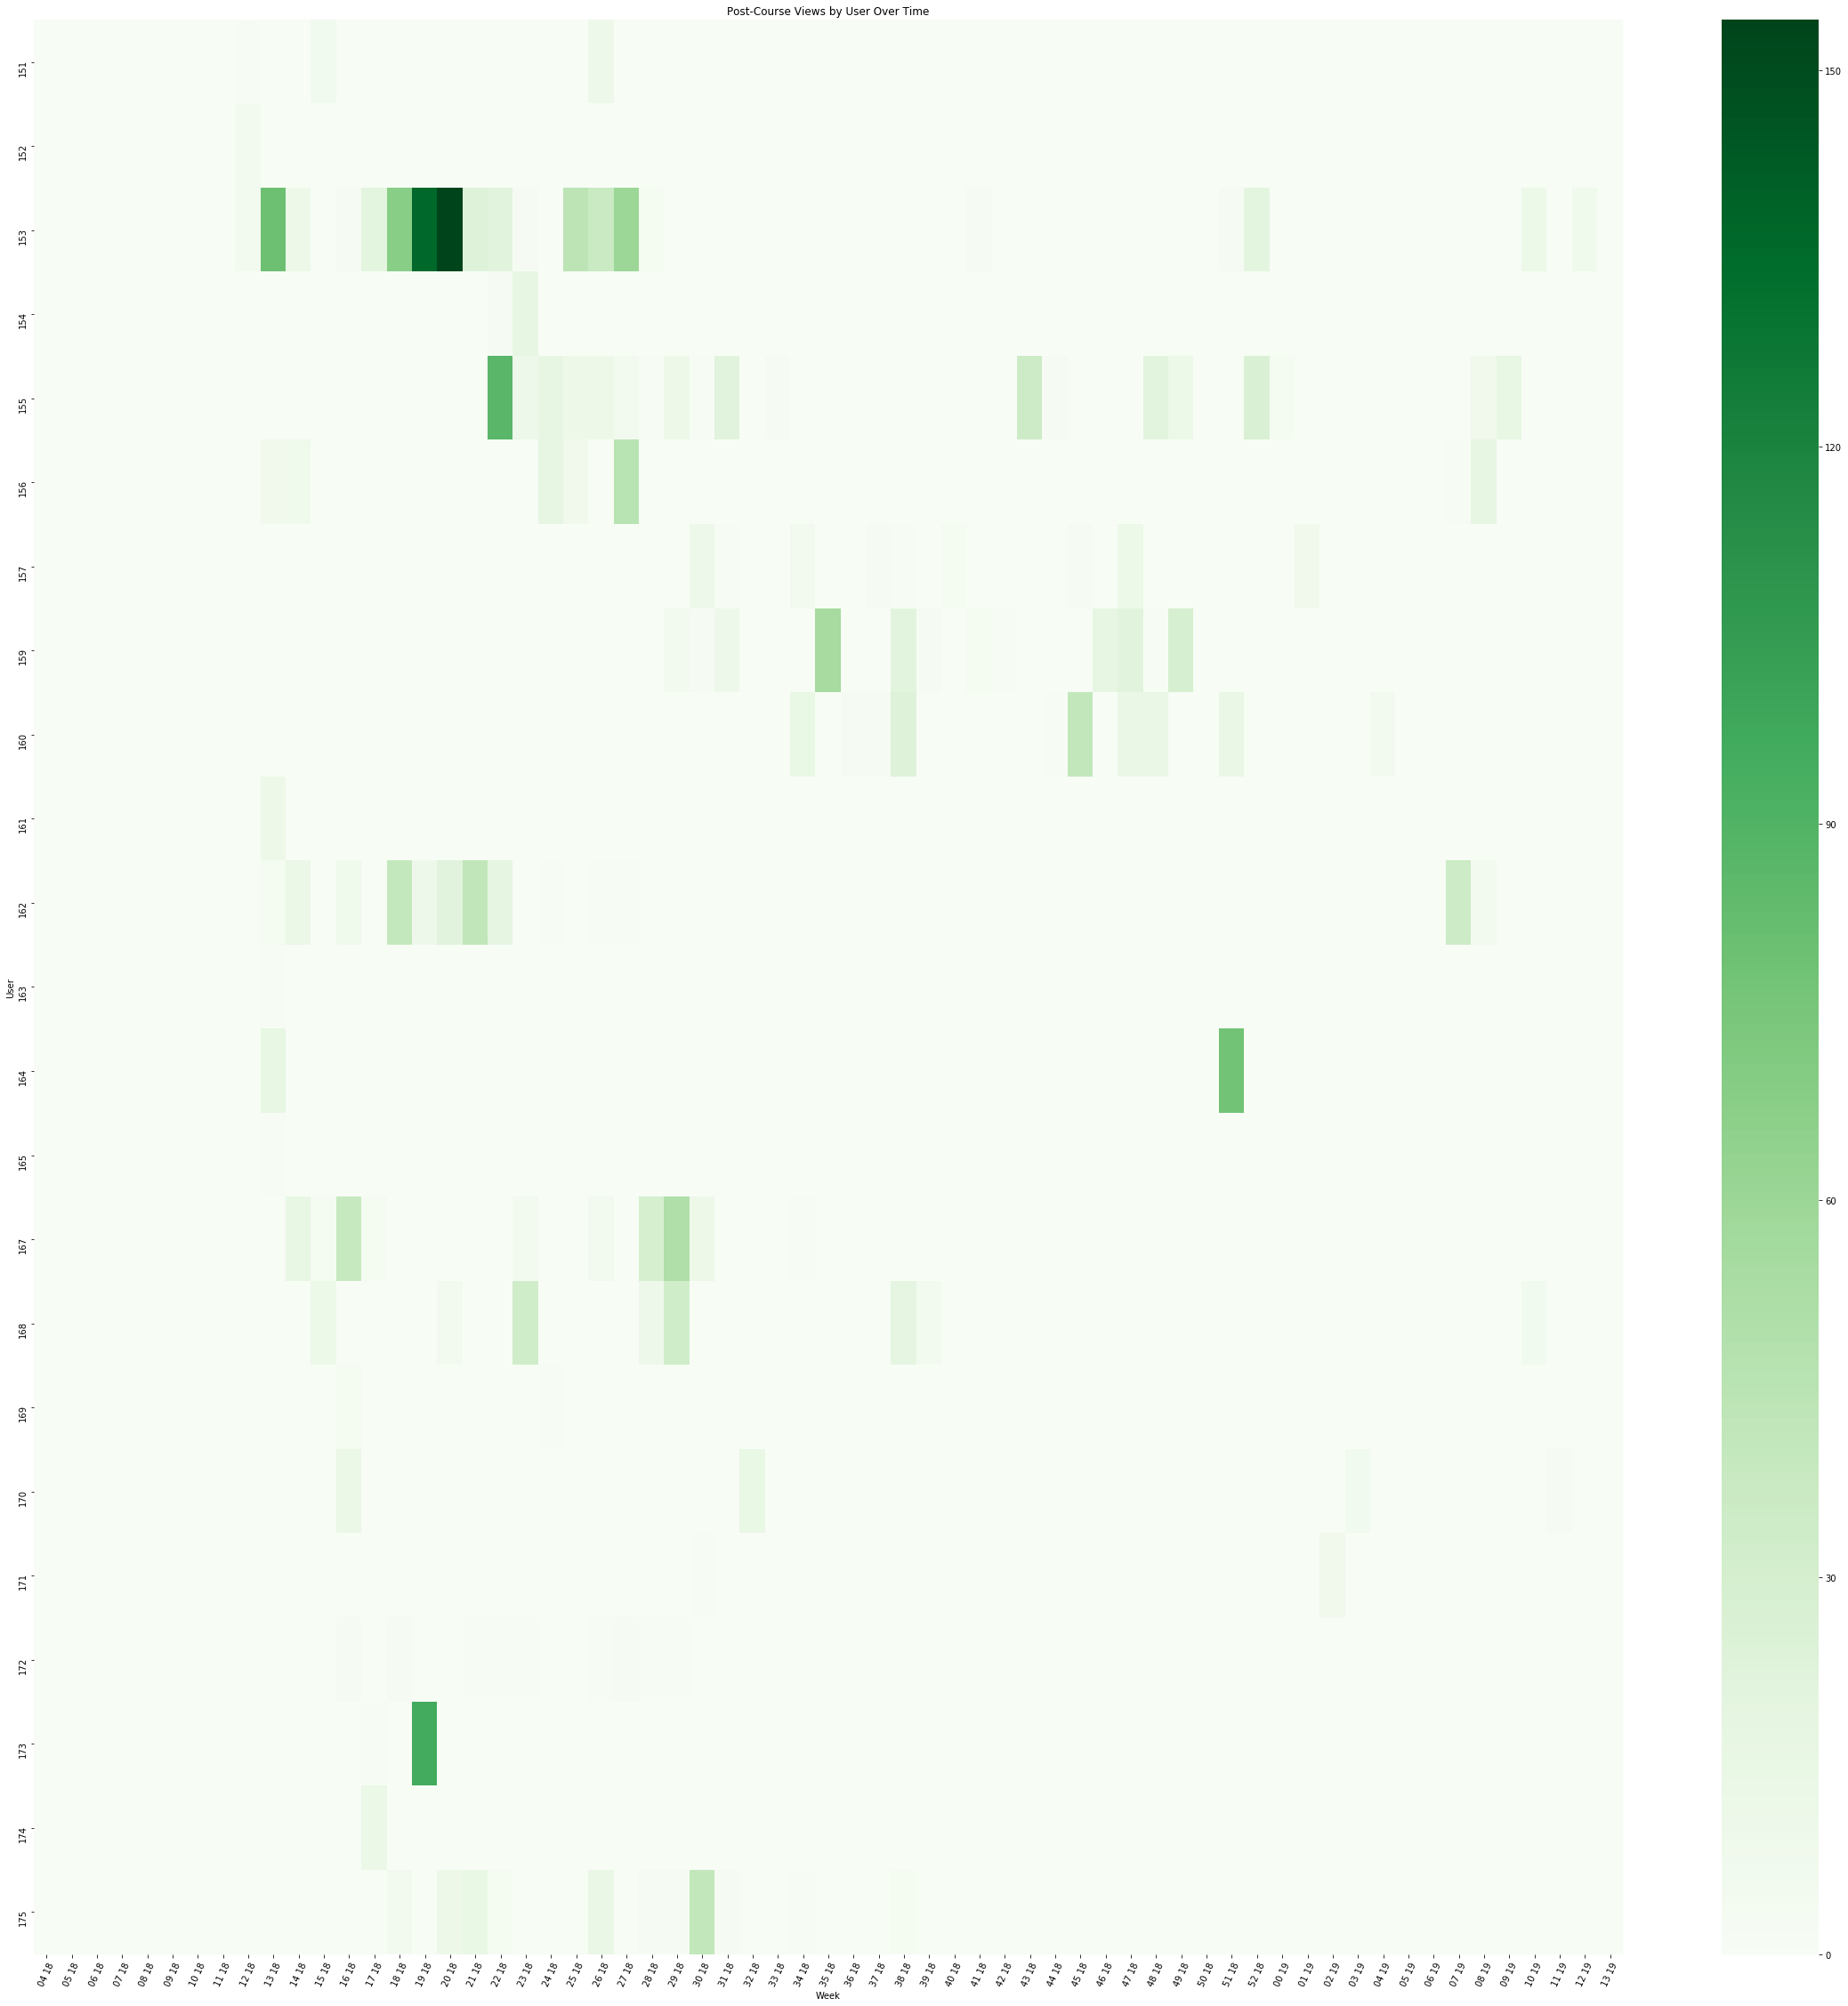

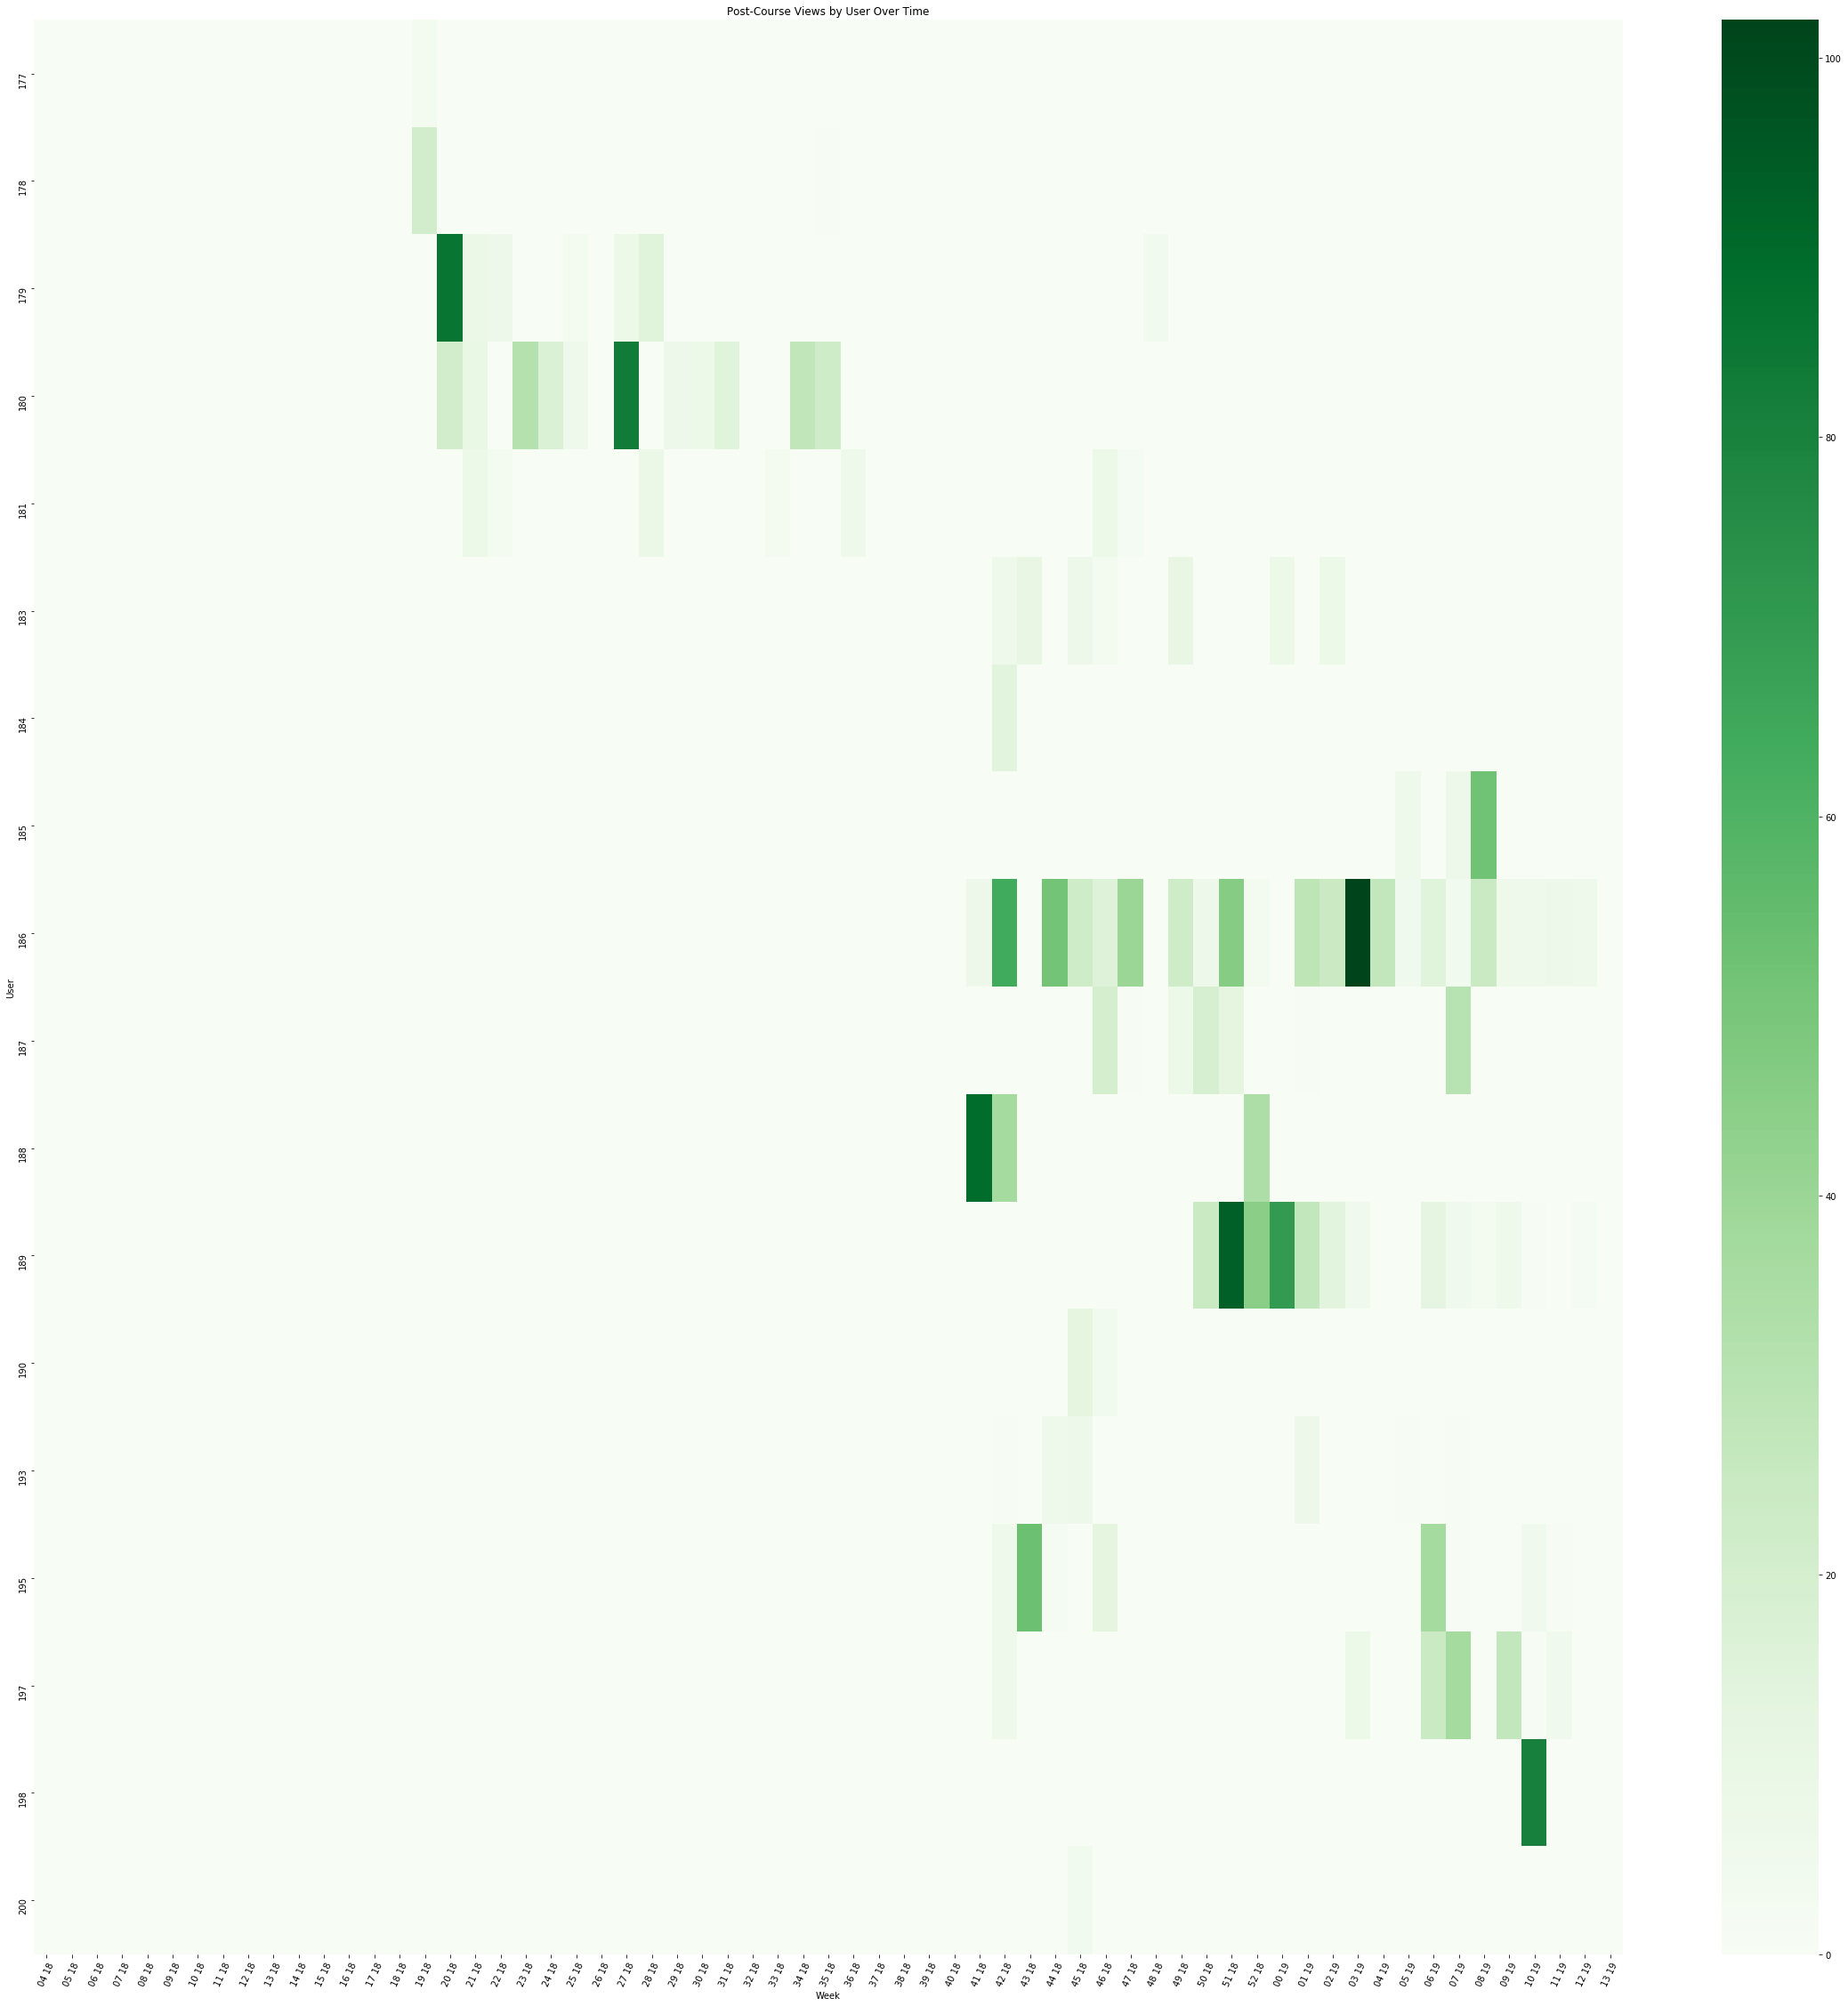

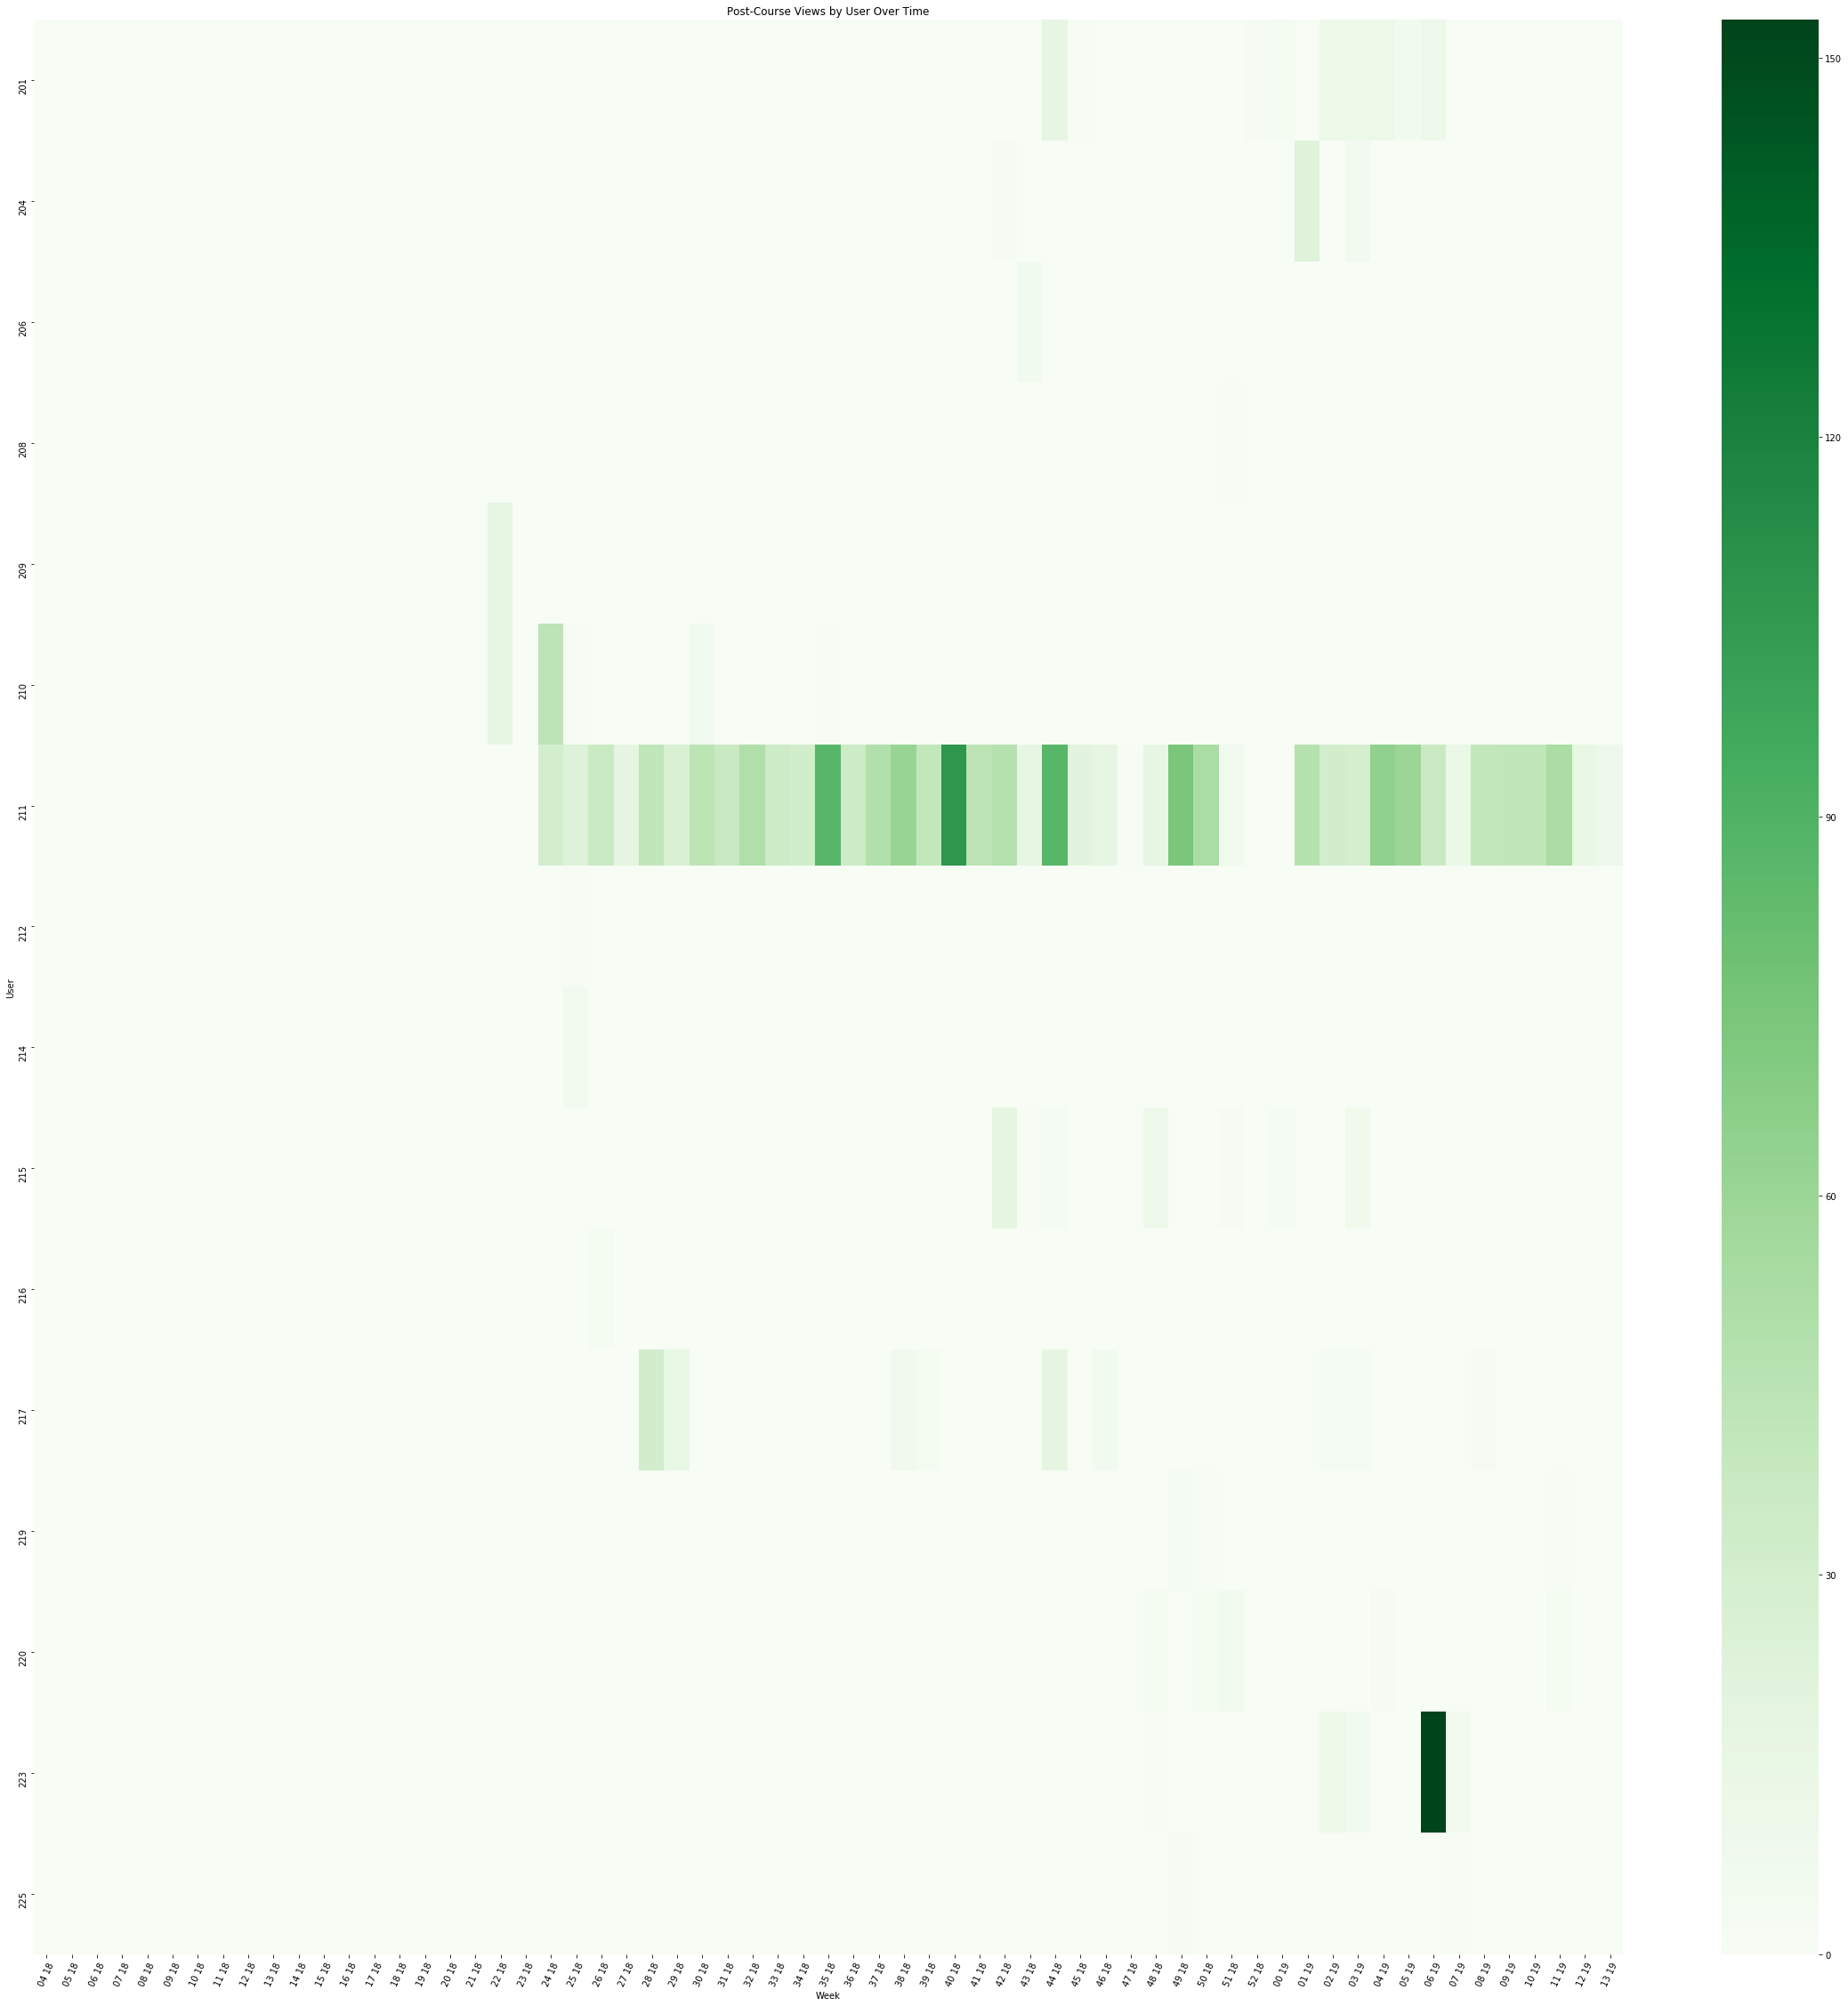

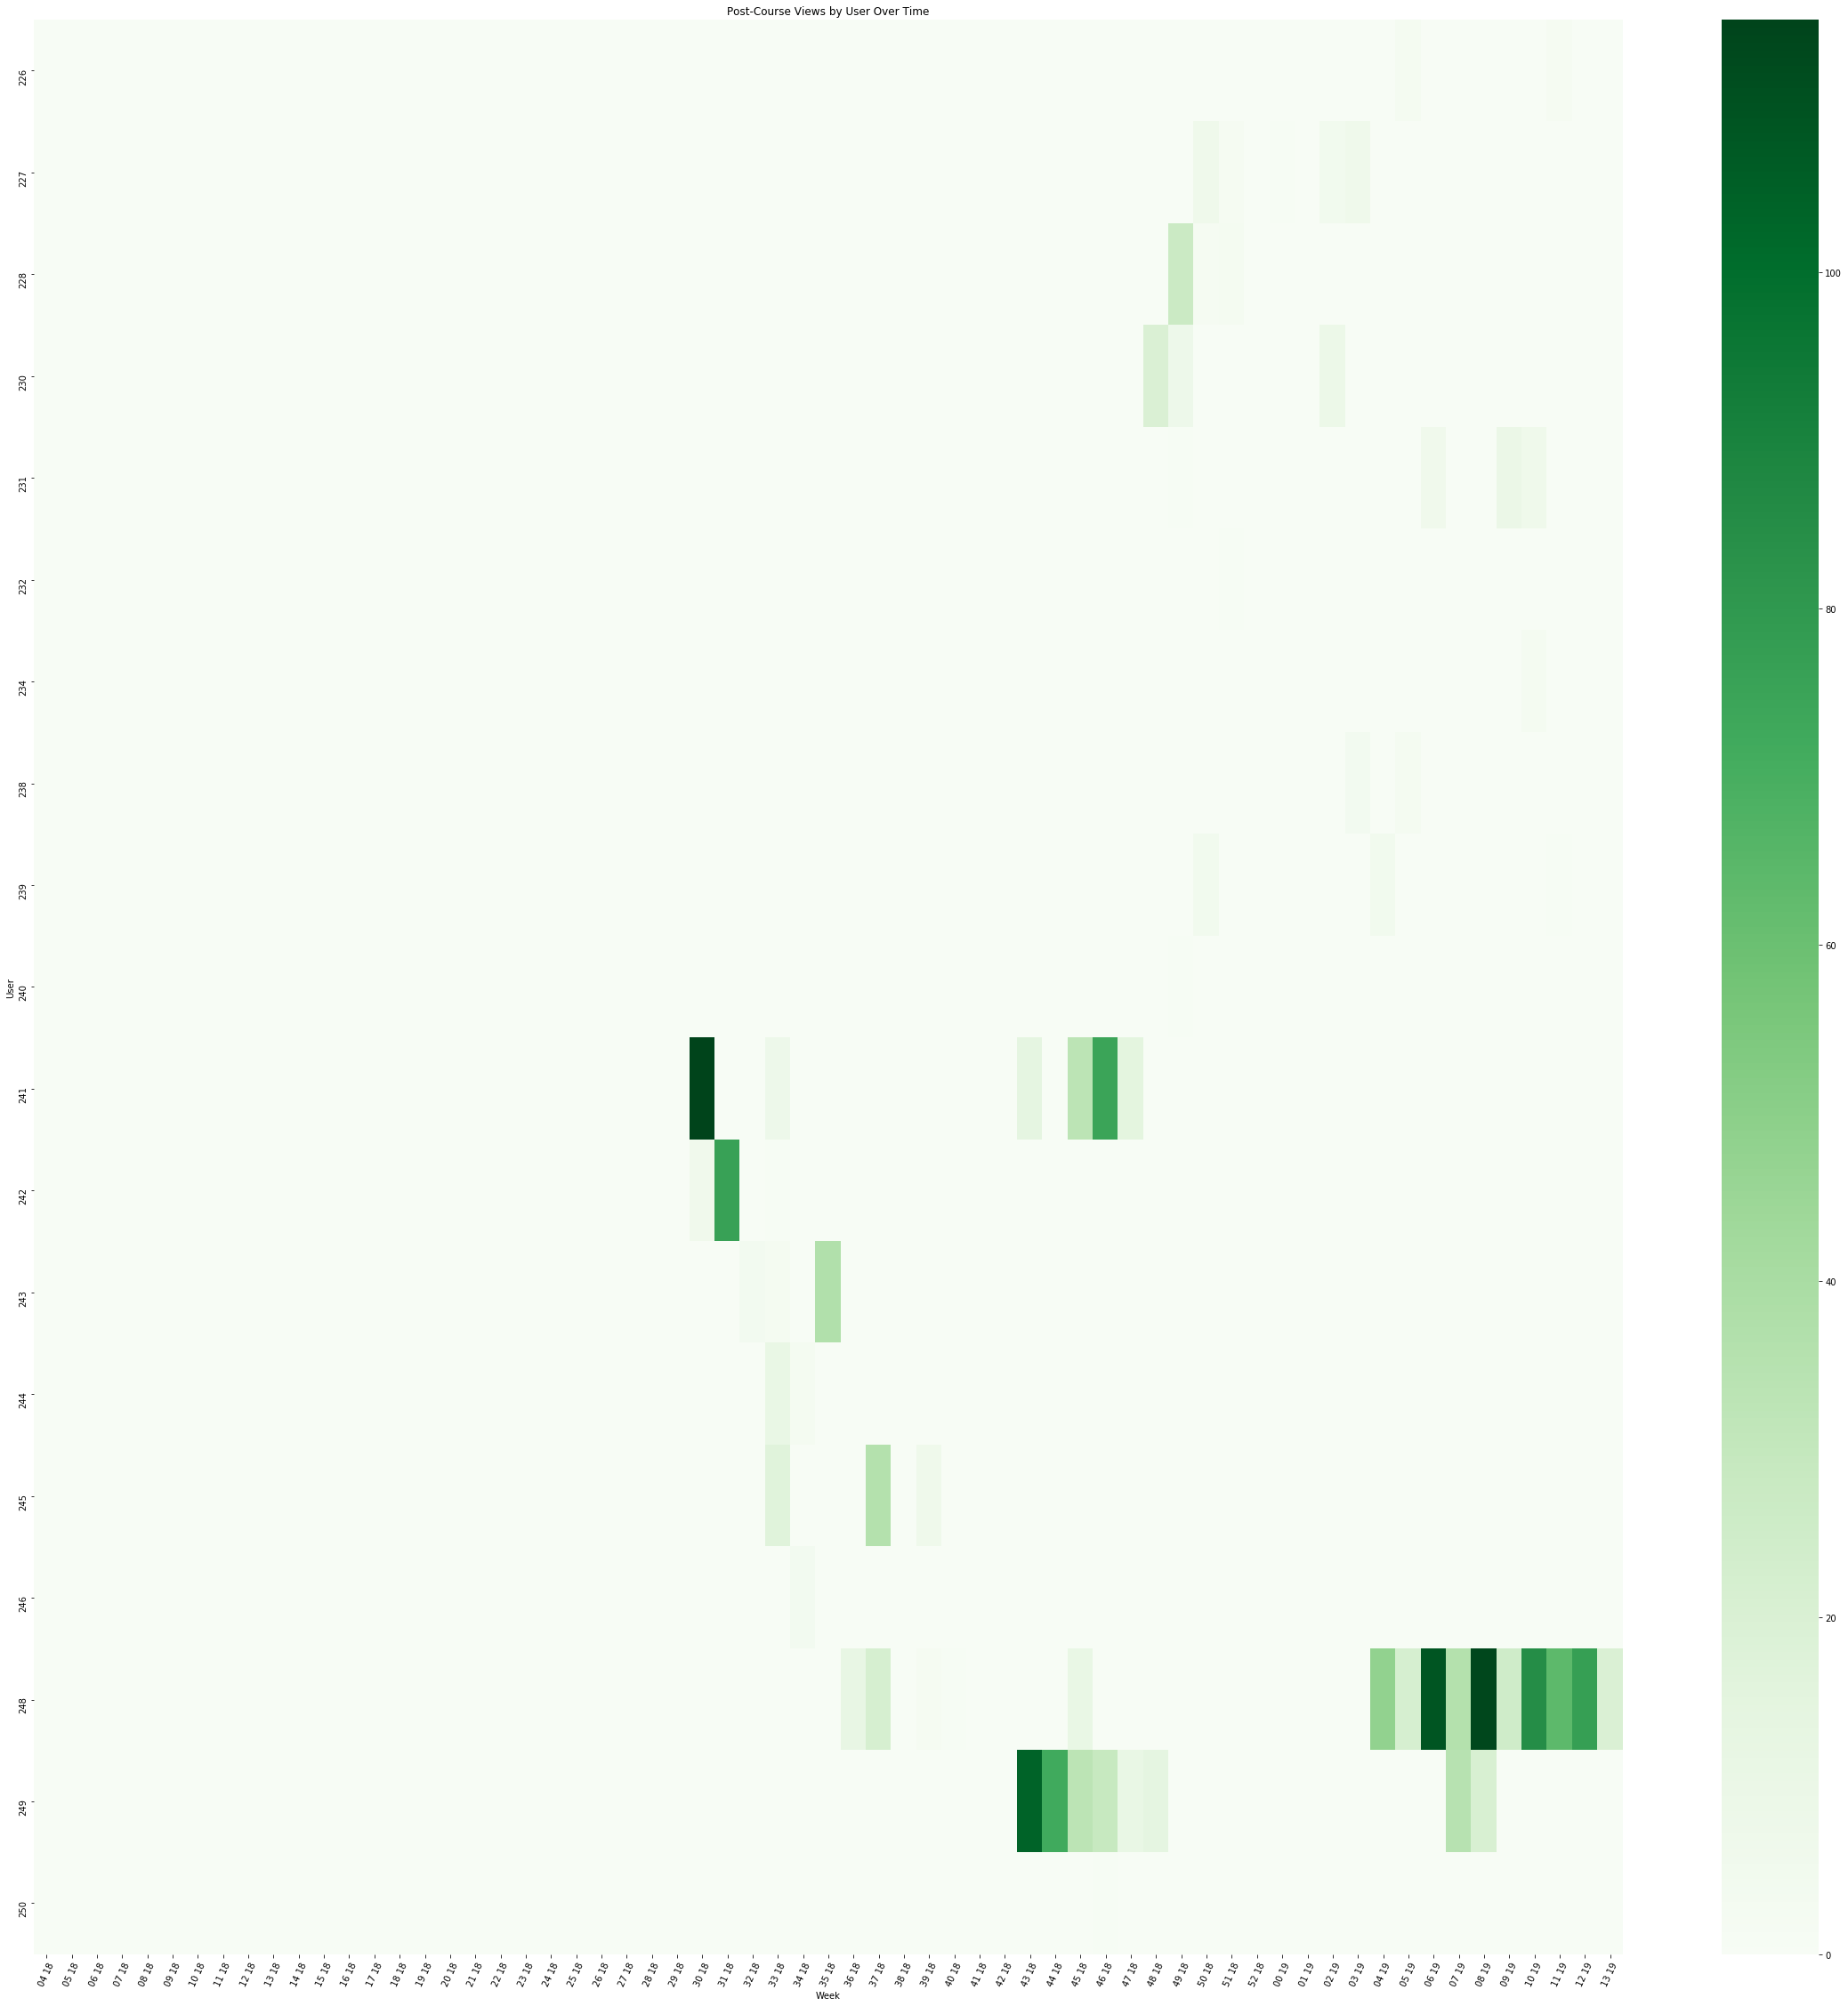

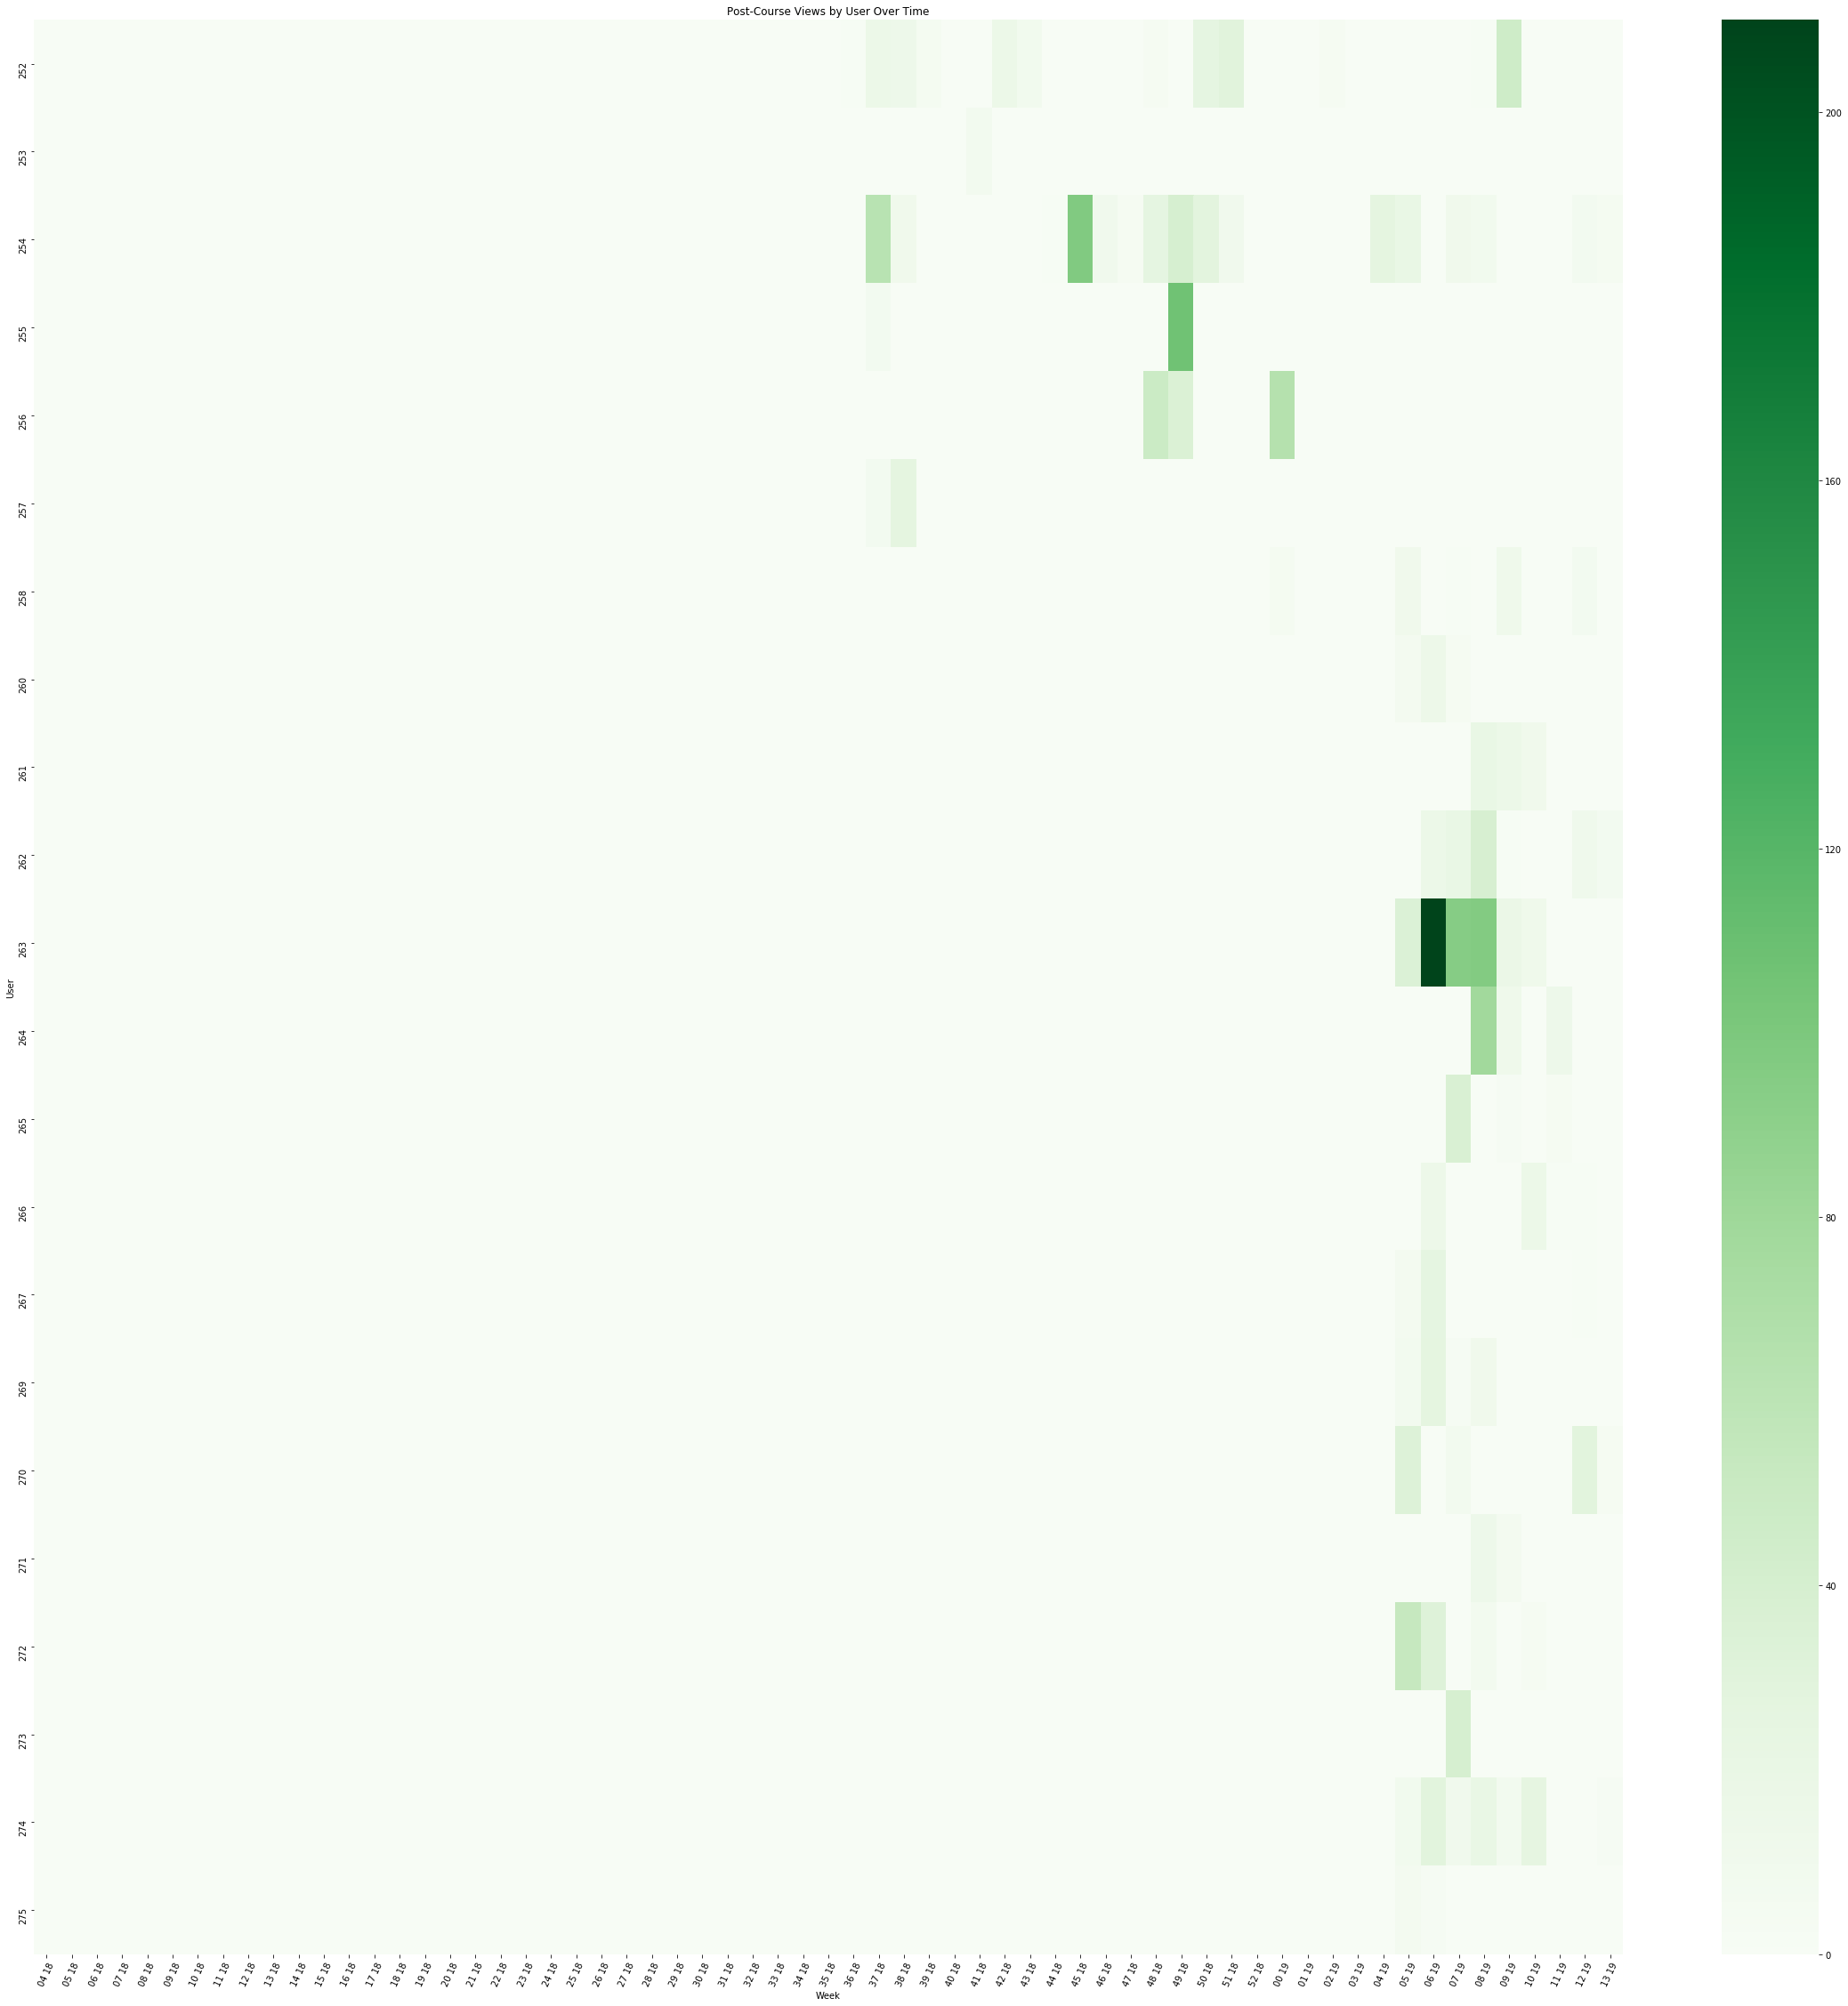

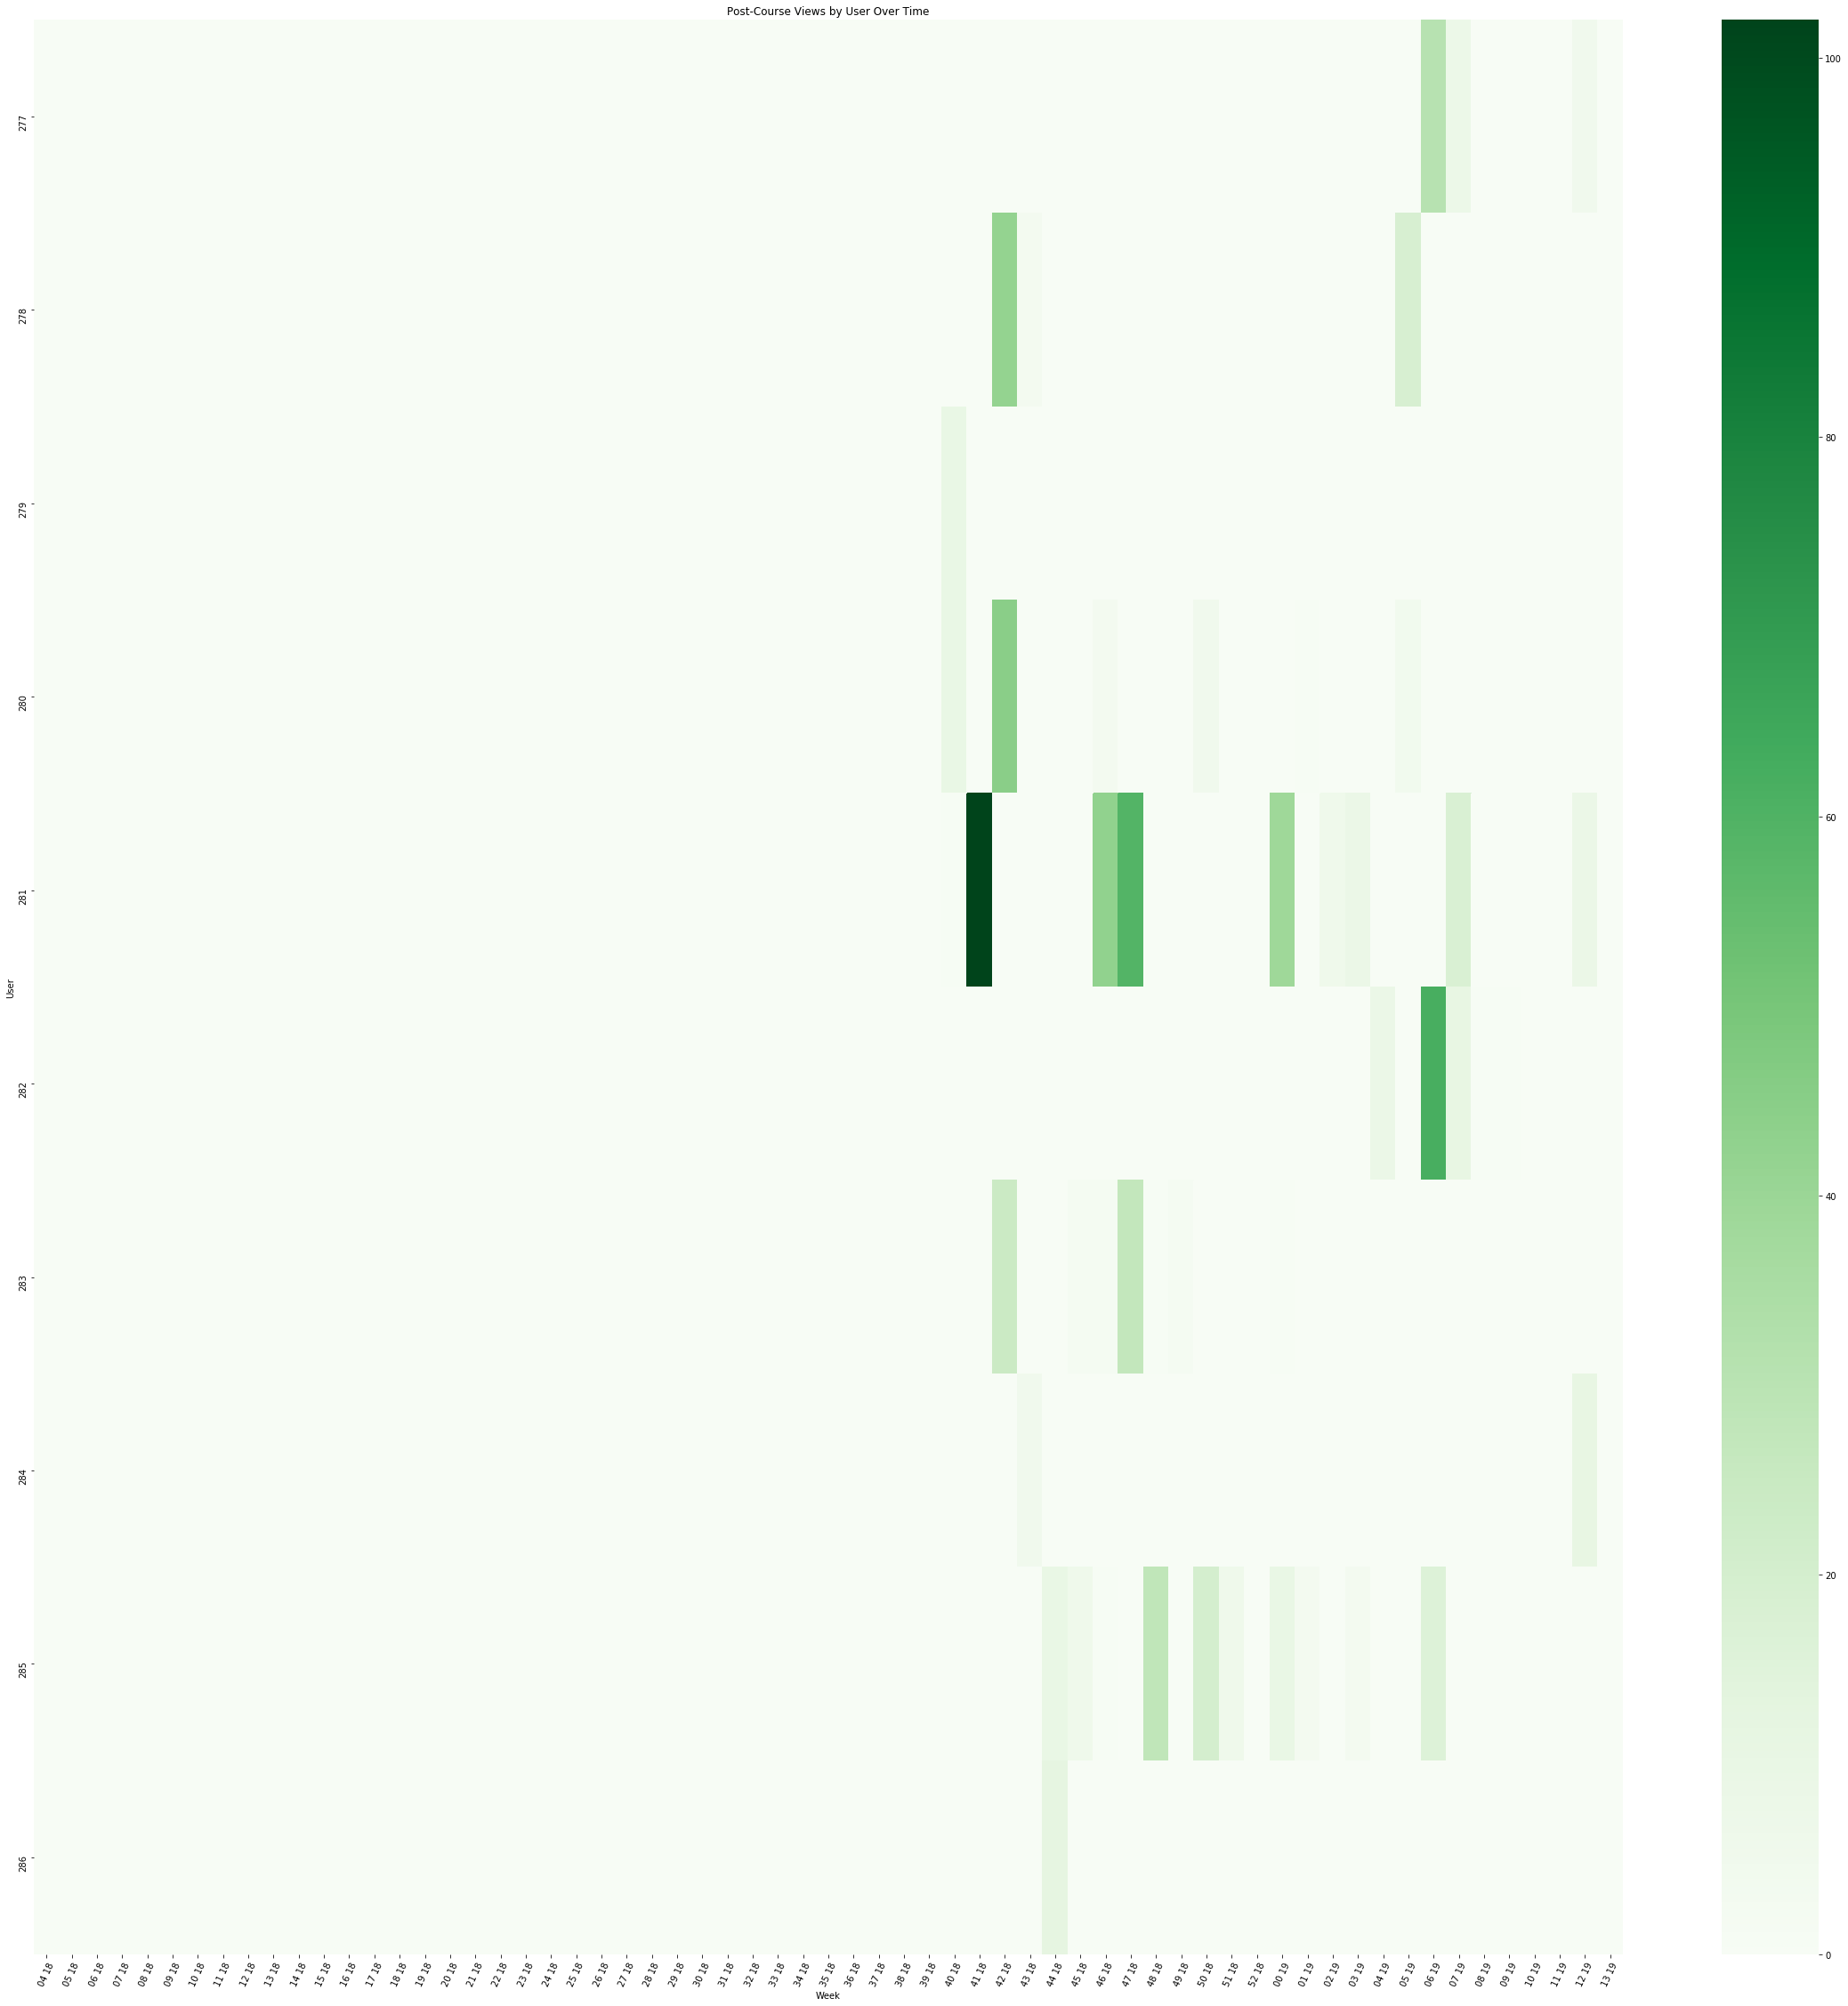

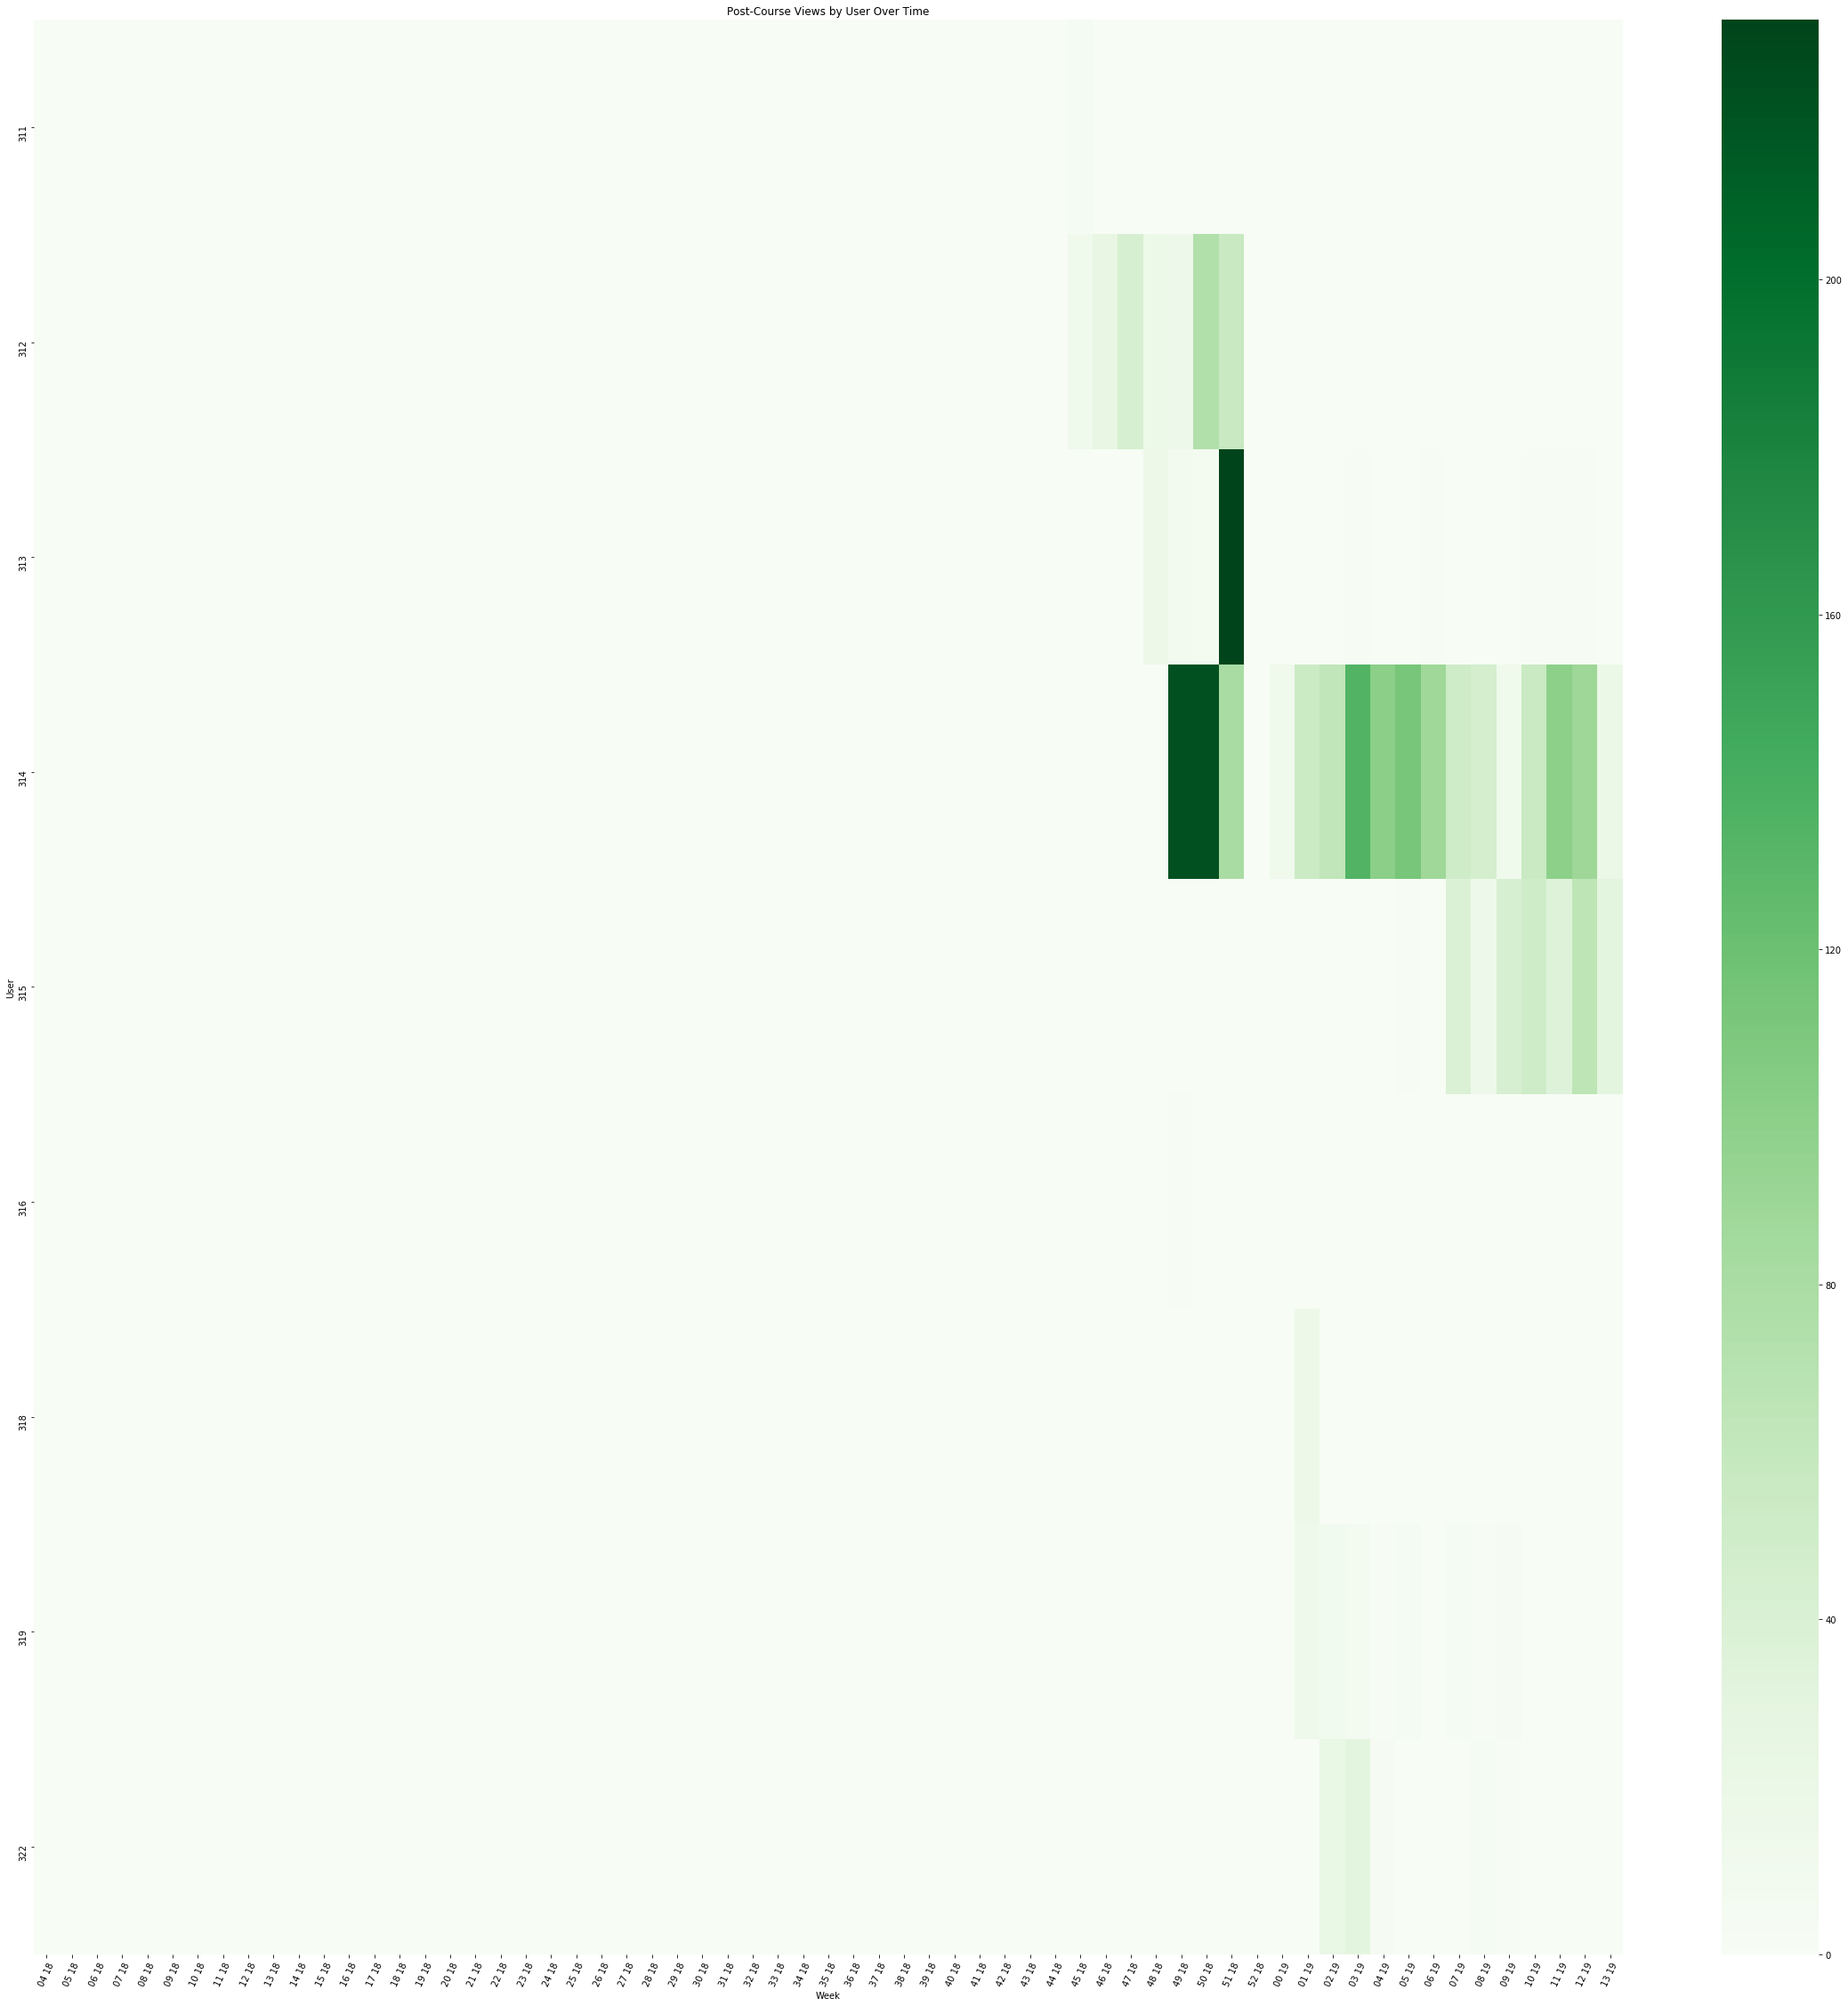

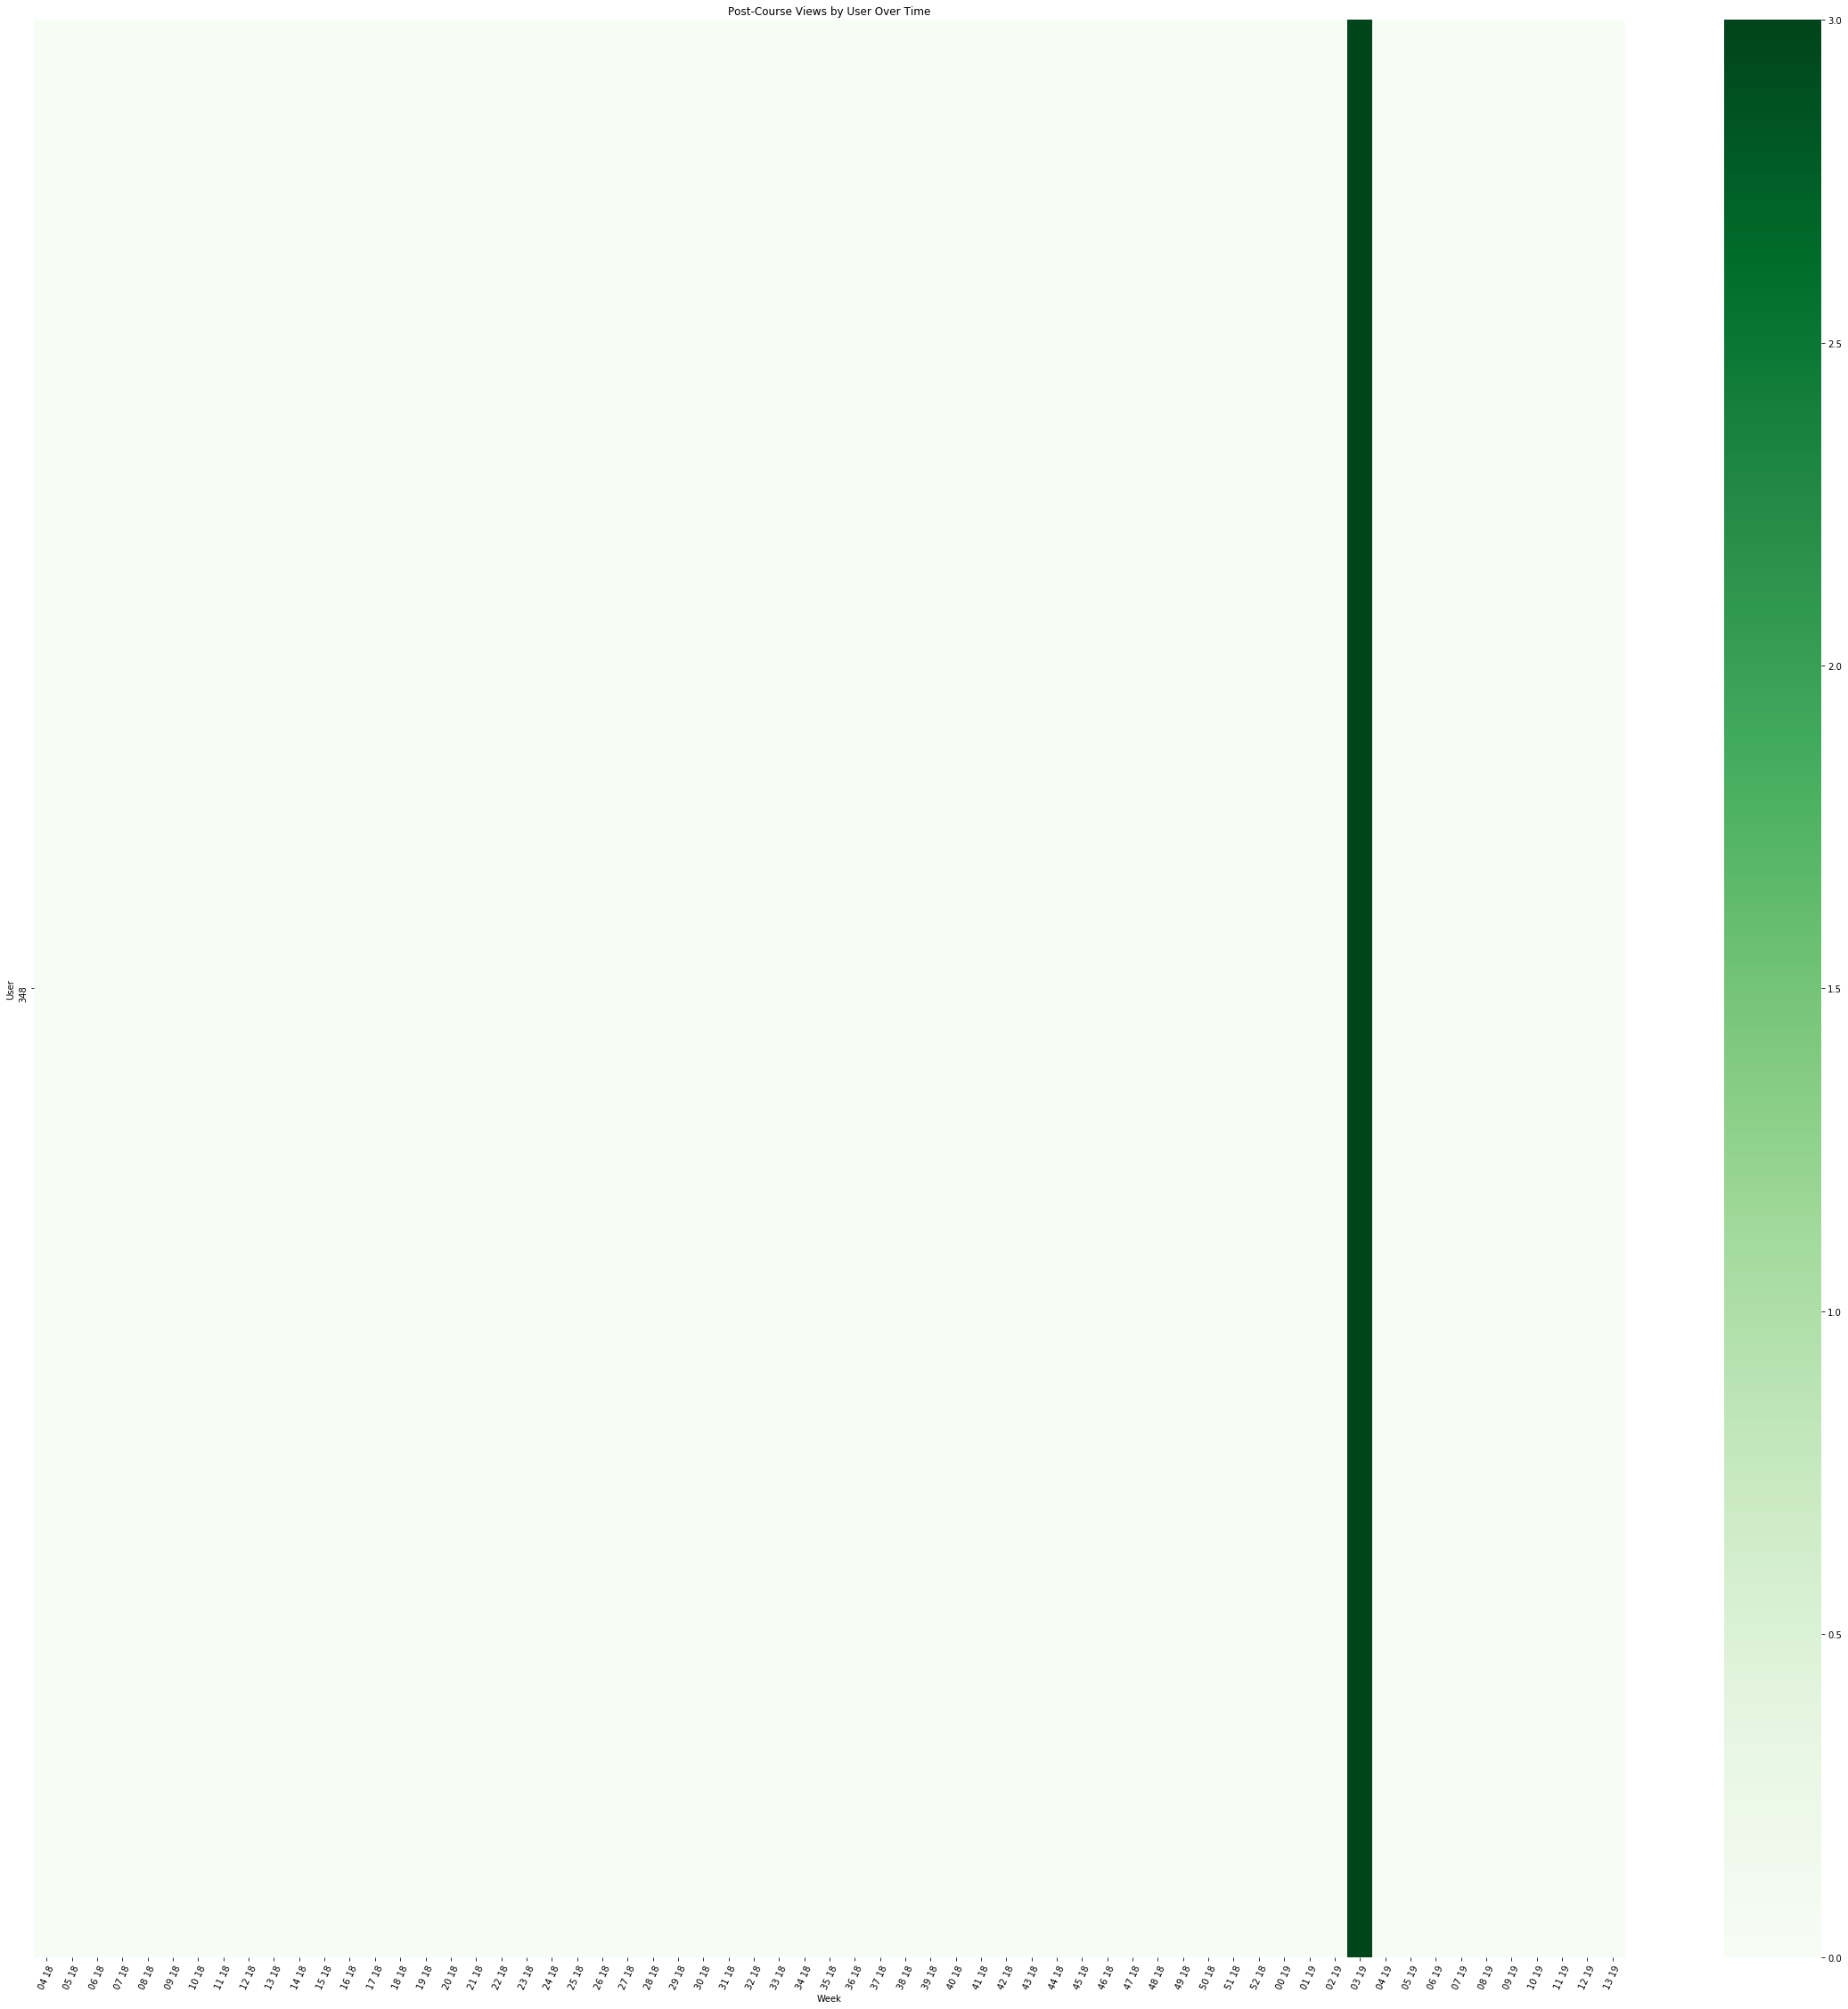

In [93]:
list_blocks = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325]
for el in list_blocks:
    us_views_by_week = user_views.resample('W').sum().loc[:, el+1:el+25]
    plt.figure(figsize=(40,40))
    sns.heatmap(us_views_by_week.T, cmap='Greens')
    # assign ticks and labels from plot
    ticks, labels = plt.xticks()
    # remake labels using datetime formatting that is preferable
    labels = us_views_by_week.index.strftime('%W %y')
    # reassign xticks with new labels
    plt.xticks(ticks, labels)
    # rotate xticks
    plt.xticks(ticks, labels, rotation=65)
    # label y axis
    plt.ylabel('User')
    # label x axis
    plt.xlabel('Week')
    # label title
    plt.title('Post-Course Views by User Over Time')

# WRITE SOME NOTES HERE FOR POSTERITY

In [94]:
# going back to df_agg after our visual exploration of outliers

In [95]:
# create list of students
students = list(df_agg.user_id.unique())

In [96]:
# make aggregate dataframe
dfa = df_agg.set_index('date').rename(index=str, columns={'hits':'ema'})

In [97]:
# bollinger band function
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    return ema.reset_index()

In [98]:
# make list of dataframes, concatinate them together after calculating bands for each
bands = []
for student in students:
    bb = bollinger_bands(dfa[dfa.user_id == student])
    bands.append(bb)

df2 = pd.concat(bands)

In [99]:
#see where our missing standard deviations are due to the moving average
df_missing = df2[df2.stdev.isnull()][['user_id','ema']]
df_missing.head()

,user_id,ema
0,1.0,7.000000
1,1.0,6.200000
2,1.0,6.173333
3,1.0,6.016889
4,1.0,6.014637


In [100]:
# make a dataframe grouping by userid to calculate null standard deviation
df_missing = df_missing.groupby('user_id').std().fillna(value=0).reset_index().rename(index=str, columns={'ema': 'stdev_null'})

In [101]:
# merge the null standard deviation onto your original
df2 = df2.merge(df_missing, on='user_id', how='left')

In [102]:
# make index of where the dataframe is null, fill with the null standard deviation calculated, 
# drop calculated null column
idx = df2.stdev.isnull()
df2.loc[idx,'stdev'] = df2.loc[idx,'stdev_null']
df2 = df2.drop(columns='stdev_null')

In [103]:
# impute upper and lower bounds that are missing now that all stdevs are filled
idx = df2.ub.isnull()
df2.loc[idx,'ub'] = df2.loc[idx,'ema'] + df2.loc[idx,'stdev']*3
df2.loc[idx,'lb'] = df2.loc[idx,'ema'] - df2.loc[idx,'stdev']*3

In [104]:
# account for any upper and lower bounds that are equal
idx = df2.ub == df2.lb
df2.loc[idx,'ub'] = df2.loc[idx,'ub'] + .01
df2.loc[idx,'lb'] = df2.loc[idx,'lb'] - .01

In [105]:
# make sure date is datetime format
df2.date = pd.to_datetime(df2.date)

In [106]:
# yes that thing again thanks
df_agg.date = pd.to_datetime(df_agg.date)

In [107]:
# merge the aggregate frame onto the original so we have our new calculated information
df2 = df2.merge(df_agg, on=['user_id', 'date'], how='left')

In [108]:
# calculate our percent b, drop stddev
df2['pct_b'] = (df2.hits-df2.lb)/(df2.ub-df2.lb)
df2 = df2.drop(columns=['stdev'])
df2.head()

,date,user_id,ema,ub,lb,hits,pct_b
0,2018-01-26,1.0,7.000000,8.176630,5.823370,7,0.500000
1,2018-01-27,1.0,6.200000,7.376630,5.023370,1,-1.709701
2,2018-01-29,1.0,6.173333,7.349963,4.996704,6,0.426343
3,2018-01-30,1.0,6.016889,7.193519,4.840259,5,0.067881
4,2018-01-31,1.0,6.014637,7.191267,4.838007,6,0.493780


In [109]:
# show us all the anomalic users that access curriculum an unusually high amount after they "graduated"
# >pretty sure some are just staff based on consistent curriculum access.
df2[df2.pct_b>1].user_id.value_counts()

11.0     64
53.0     63
64.0     59
1.0      48
211.0    46
26.0     23
41.0     21
40.0     20
50.0     17
60.0     16
127.0    16
153.0    14
10.0     13
314.0    12
142.0    10
186.0    10
27.0     10
128.0     9
67.0      9
248.0     9
96.0      8
110.0     8
56.0      8
52.0      8
315.0     8
312.0     7
36.0      7
72.0      7
252.0     6
37.0      6
         ..
136.0     1
370.0     1
210.0     1
283.0     1
102.0     1
16.0      1
29.0      1
22.0      1
178.0     1
280.0     1
164.0     1
19.0      1
284.0     1
228.0     1
140.0     1
272.0     1
109.0     1
264.0     1
198.0     1
126.0     1
257.0     1
65.0      1
313.0     1
254.0     1
242.0     1
105.0     1
269.0     1
173.0     1
160.0     1
267.0     1
Name: user_id, Length: 137, dtype: int64

### Exercise 3: Clustering - DBSCAN
### Use dbscan to detect anomalies in other products from the customers dataset.

### Use dbscan to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

#### DBSCAN process bullets:
#### -2+ numeric variables
#### -nparray dtype = float
#### -standard normal-scale
#### -DBSCAN object with parameters: eps, min_samples
#### -fit object on standardized array
#### -extract labels
#### -add to DF to analyze/explore
#### -plot

In [111]:
# some more environment setup
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [112]:
# read in customers csv
dfo = pd.read_csv('customers.csv')

In [113]:
dfo.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [114]:
# drop channel and region
df = dfo[['Grocery', 'Milk', 'Fresh']]
df1 = dfo[['Grocery','Detergents_Paper','Frozen']]

In [115]:
# create a numpy array of float types
np_array = df.values.astype('float32', copy=False)

In [116]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.0411149 ,  0.5235678 ,  0.05293319],
       [ 0.17031837,  0.5444577 , -0.39130196],
       [-0.0281571 ,  0.40853772, -0.44702926],
       [-0.3929769 , -0.62402   ,  0.1001114 ],
       [-0.07935619, -0.05239645,  0.8402394 ],
       [-0.29763708,  0.3340666 , -0.20480551],
       [-0.10284877, -0.35231563,  0.00995035],
       [ 0.15535896, -0.11398095, -0.34998146],
       [-0.18533617, -0.2914094 , -0.4779009 ],
       [ 1.1514235 ,  0.7184949 , -0.4744971 ]], dtype=float32)

In [117]:
dbsc = DBSCAN(eps = 0.75, min_samples = 15).fit(np_array)

In [118]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [119]:
df['labels'] = labels
df.labels.value_counts()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


 0    400
-1     40
Name: labels, dtype: int64

In [120]:
df[df.labels==-1].head()

,Grocery,Milk,Fresh,labels
12,11757,12319,31714,-1
23,22019,36423,26373,-1
28,25957,20484,4113,-1
39,902,555,56159,-1
45,21531,22044,5181,-1


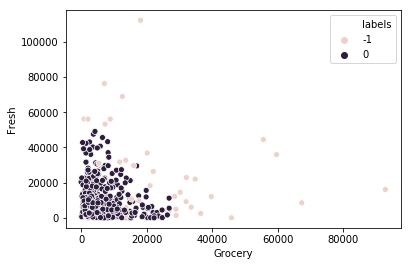

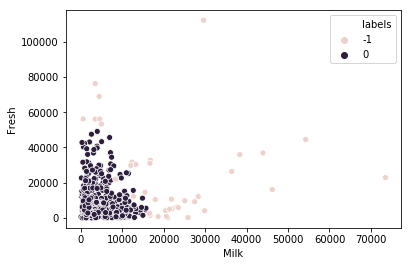

In [121]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

Text(0.5, 0, 'Grocery')

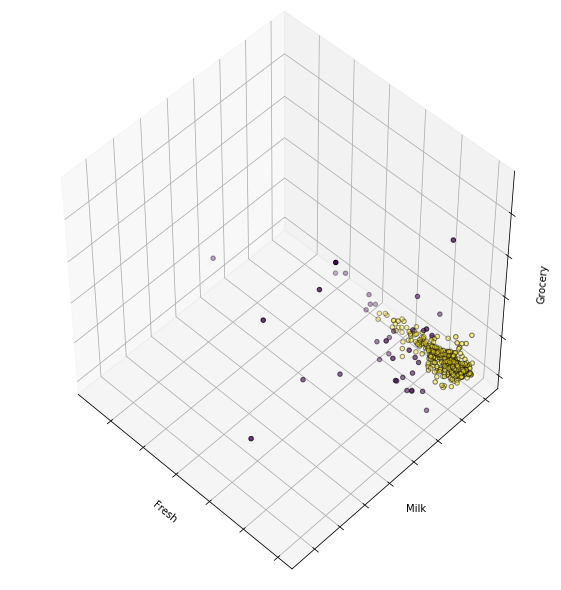

In [122]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

In [123]:
#try with another thing:
df1 = dfo[['Grocery','Detergents_Paper','Frozen']]
np_array1 = df1.values.astype('float32', copy=False)
stscaler1 = StandardScaler().fit(np_array1)
np_array1 = stscaler.transform(np_array1)

In [124]:
dbsc1 = DBSCAN(eps = 0.75, min_samples = 15).fit(np_array1)

In [125]:
labels = dbsc1.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [126]:
df1['labels'] = labels
df1.labels.value_counts()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


 0    424
-1     16
Name: labels, dtype: int64

In [127]:
df1.head()

,Grocery,Detergents_Paper,Frozen,labels
0,7561,2674,214,0
1,9568,3293,1762,0
2,7684,3516,2405,0
3,4221,507,6404,0
4,7198,1777,3915,0


Text(0.5, 0, 'Frozen')

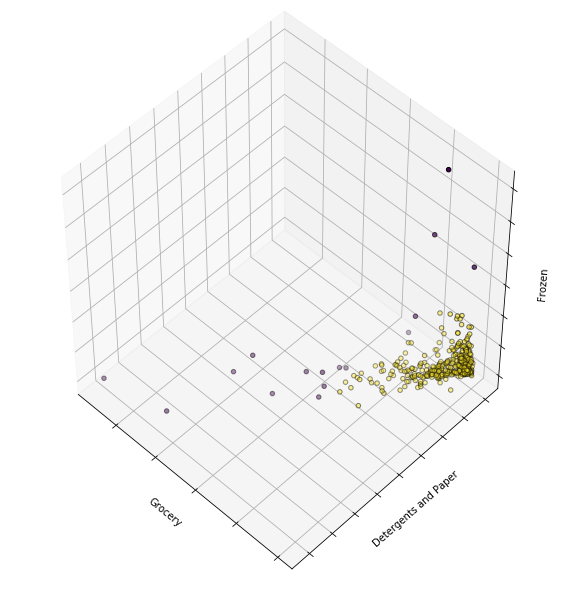

In [128]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df1.Grocery, df1.Detergents_Paper, df1.Frozen,
           c=df1.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Grocery')
ax.set_ylabel('Detergents and Paper')
ax.set_zlabel('Frozen')

In [129]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 4 columns):
Grocery             440 non-null int64
Detergents_Paper    440 non-null int64
Frozen              440 non-null int64
labels              440 non-null int64
dtypes: int64(4)
memory usage: 13.8 KB


In [130]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [131]:
dfhmm = dfo
dfhmm['labels'] = df1['labels']

In [132]:
dfhmm[dfhmm.labels==-1]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
47,2,3,44466,54259,55571,7782,24171,6465,-1
61,2,3,35942,38369,59598,3254,26701,2017,-1
65,2,3,85,20959,45828,36,24231,1423,-1
85,2,3,16117,46197,92780,1026,40827,2944,-1
86,2,3,22925,73498,32114,987,20070,903,-1
92,2,3,9198,27472,32034,3232,18906,5130,-1
93,1,3,11314,3090,2062,35009,71,2698,-1
109,2,3,1406,16729,28986,673,836,3,-1
145,2,3,22039,8384,34792,42,12591,4430,-1
181,1,3,112151,29627,18148,16745,4948,8550,-1


In [133]:
dfhmm.drop(columns=['Channel', 'Region']).describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,-0.036364
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,0.187406
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,-1.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,0.000000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,0.000000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,0.000000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,0.000000


## Use dbscan to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [135]:
import acquire_zillow
import prepare_zillow

In [136]:
dfz = acquire_zillow.get_zillow()

In [137]:
dfz = prepare_zillow.prep_zillow(dfz)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


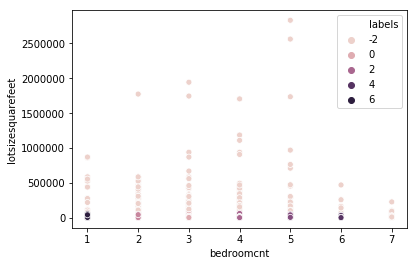

In [138]:
## -2+ numeric variables
dfbdsqft = dfz[['bedroomcnt','lotsizesquarefeet']]
## -nparray dtype = float
npz = dfbdsqft.values.astype('float32', copy=False)
## -standard normal-scale
stscalerz = StandardScaler().fit(npz)
npz = stscalerz.transform(npz)
## -DBSCAN object with parameters: eps, min_samples
dbzlol = DBSCAN(eps = 0.9, min_samples = 200).fit(npz)
## -fit object on standardized array ^^
## -extract labels
labelz = dbzlol.labels_
## -add to DF to analyze/explore
dfbdsqft['labels'] = labelz
## -plot
sns.scatterplot(dfbdsqft.bedroomcnt, dfbdsqft.lotsizesquarefeet, hue=dfbdsqft.labels)
plt.show()

In [139]:
dbzlol = DBSCAN(eps = 0.9, min_samples = 200).fit(npz)
labelz = dbzlol.labels_
dfbdsqft['labels'] = labelz
dfbdsqft.labels.value_counts()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


 0    31613
 2    16880
 1    11815
 3     4035
 4      625
 5      614
-1      476
Name: labels, dtype: int64

## playing with mall data

In [140]:
import acquire_mall
import prepare_mall

In [141]:
dfmall = prepare_mall.prep_mall_data(acquire_mall.get_mall_data())

In [142]:
dfmall.head()

,gender,age,annual_income,spending_score,gender_e
customer_id,,,,,
1,Male,19,15,39,1
2,Male,21,15,81,1
3,Female,20,16,6,0
4,Female,23,16,77,0
5,Female,31,17,40,0


In [143]:
## -2+ numeric variables
dfmall = dfmall[['age','annual_income','spending_score']]
## -nparray dtype = float
npmall = dfmall.values.astype('float32', copy=False)
## -standard normal-scale
stscaler_mall = StandardScaler().fit(npmall)
npmall = stscaler_mall.transform(npmall)
## -DBSCAN object with parameters: eps, min_samples
dbmall = DBSCAN(eps = 0.9, min_samples = 10).fit(npmall)
## -fit object on standardized array ^^
## -extract labels
labels = dbmall.labels_
## -add to DF to analyze/explore
dfmall['labels'] = labels
dfmall.labels.value_counts()

 0    191
-1      9
Name: labels, dtype: int64

Text(0.5, 0, 'spending_score')

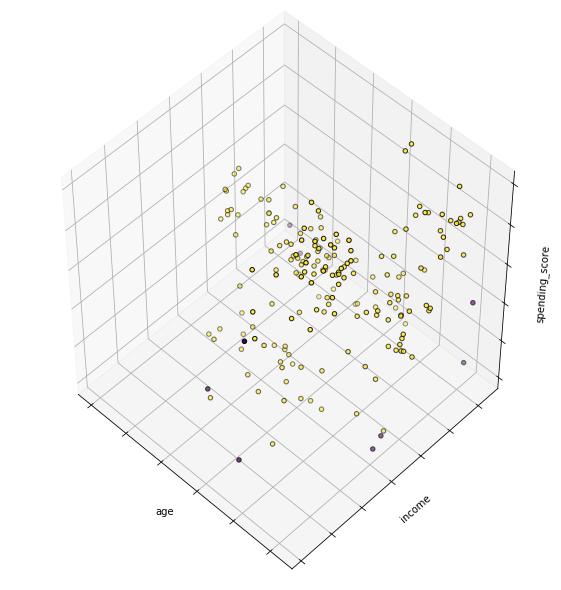

In [144]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(dfmall.age, dfmall.annual_income, dfmall.spending_score,
           c=dfmall.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('age')
ax.set_ylabel('income')
ax.set_zlabel('spending_score')

In [145]:
dfmall[dfmall.labels == -1]

,age,annual_income,spending_score,labels
customer_id,,,,
1,19,15,39,-1
3,20,16,6,-1
9,64,19,3,-1
11,67,19,14,-1
135,20,73,5,-1
163,19,81,5,-1
197,45,126,28,-1
199,32,137,18,-1
200,30,137,83,-1


good set of anomalies here: few older folks with high incomes that have an exceptionally low spending score as well as some young people with low incomes and high spending scores.

customer #163 is an anomaly: under 20 years old with an 81k income. Exceptionally low spending score.

In [146]:
dfmall[(dfmall.annual_income > 50) & (dfmall.age < 35)]

,age,annual_income,spending_score,labels
customer_id,,,,
76,26,54,54,0
79,23,54,52,0
85,21,54,57,0
88,22,57,55,0
89,34,58,60,0
92,18,59,41,0
95,32,60,42,0
96,24,60,52,0
98,27,60,50,0
